In [ ]:
pip install ta

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ta
import math

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('US_ETF_dailyReturns_feb2024.xlsx', skiprows=5)
df.drop(df.columns[0], axis=1, inplace=True)
new_columns = ['Date','XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'SMH', 'XTL', 'XLU', 'IYR', 'SPY']
df.columns = new_columns
df = df.dropna(subset=['Date'])
df = df.iloc[:,:-2]

data = df.copy()
data

Date       XLE       XLB       XLI       XLY       XLP       XLV  \
0    2012-01-02   69.1300   33.5000   33.7500   39.0200   32.4900   34.6900   
1    2012-01-03   71.0500   34.4300   34.4900   39.3500   32.4600   35.1400   
2    2012-01-04   71.2000   34.7200   34.6500   39.6600   32.3900   34.9700   
3    2012-01-05   70.8600   34.8200   34.6600   39.9900   32.3700   35.0700   
4    2012-01-06   70.4400   34.7700   34.5900   40.0500   32.1600   35.1300   
...         ...       ...       ...       ...       ...       ...       ...   
3170 2024-02-26  132.5318  110.8400  151.3750  211.0369  102.5136  179.6522   
3171 2024-02-27  131.9634  111.2509  151.6020  211.7332  102.5274  179.2125   
3172 2024-02-28  131.7022  111.5977  152.1190  212.5688  102.6375  178.3210   
3173 2024-02-29  132.3475  112.4452  152.5856  214.0078  102.4723  176.8676   
3174 2024-03-01  134.0392  113.1002  152.9639  214.5475  102.4379  178.4614   

          XLF       SMH      XTL      XLU  
0     10.5562   15.2150  41.8000  35.9800  
1     10.8323   15.4250  42.9999  35.3400  
2     10.7998   15.4350  41.8620  35.1400  
3     10.9460   15.6250  41.6700  35.2100  
4     10.8770   15.6050  41.6395  35.0200  
...       ...       ...      ...      ...  
3170  50.4369  245.6889  87.9472  91.4811  
3171  50.5753  244.9764  88.6005  93.2131  
3172  50.7640  242.2550  87.7009  93.4993  
3173  50.7388  247.5577  88.2741  93.5294  
3174  50.6386  256.4345  88.8544  92.4224  

[3175 rows x 11 columns]

In [ ]:
columns = ['XLE',	'XLB',	'XLI',	'XLY',	'XLP',	'XLV',	'XLF',	'SMH',	'XTL',	'XLU']

def BB(df, asset, window=15):

  bollinger_indicator = ta.volatility.BollingerBands(df[asset], window, window_dev=2)
  df['bb_hband'] = bollinger_indicator.bollinger_hband()
  df['bb_lband'] = bollinger_indicator.bollinger_lband()

  df[f'{asset}_BB'] = 0
  df.loc[df[asset] < df['bb_lband'], f'{asset}_BB'] = 1
  df.loc[df[asset] > df['bb_hband'], f'{asset}_BB'] = -1

  df[f'{asset}_BB'] = df[f'{asset}_BB'].shift(1)

  return df


In [ ]:
for column in columns:
    data[f'{column}_return'] = data[column].pct_change()
    BB(data, column)

In [ ]:
returns_data = data.filter(like='_return')
returns_data

XLE_return  XLB_return  XLI_return  XLY_return  XLP_return  XLV_return  \
0            NaN         NaN         NaN         NaN         NaN         NaN   
1       0.027774    0.027761    0.021926    0.008457   -0.000923    0.012972   
2       0.002111    0.008423    0.004639    0.007878   -0.002157   -0.004838   
3      -0.004775    0.002880    0.000289    0.008321   -0.000617    0.002860   
4      -0.005927   -0.001436   -0.002020    0.001500   -0.006487    0.001711   
...          ...         ...         ...         ...         ...         ...   
3170    0.003490   -0.005989   -0.001497    0.003089   -0.004013   -0.005140   
3171   -0.004289    0.003707    0.001500    0.003299    0.000135   -0.002448   
3172   -0.001979    0.003117    0.003410    0.003946    0.001074   -0.004975   
3173    0.004900    0.007594    0.003067    0.006770   -0.001610   -0.008150   
3174    0.012782    0.005825    0.002479    0.002522   -0.000336    0.009011   

      XLF_return  SMH_return  XTL_return  XLU_return  
0            NaN         NaN         NaN         NaN  
1       0.026155    0.013802    0.028706   -0.017788  
2      -0.003000    0.000648   -0.026463   -0.005659  
3       0.013537    0.012310   -0.004586    0.001992  
4      -0.006304   -0.001280   -0.000732   -0.005396  
...          ...         ...         ...         ...  
3170   -0.004964    0.008292    0.007200   -0.019691  
3171    0.002744   -0.002900    0.007428    0.018933  
3172    0.003731   -0.011109   -0.010153    0.003070  
3173   -0.000496    0.021889    0.006536    0.000322  
3174   -0.001975    0.035857    0.006574   -0.011836  

[3175 rows x 10 columns]

In [ ]:
for column in columns:
  ma_2 = data[column].rolling(window=2).mean().shift(1).ffill()
  ma_10 = data[column].rolling(window=10).mean().shift(1).ffill()
  ma_60 = data[column].rolling(window=60).mean().shift(1).ffill()
  data[f'{column}_MAXO(10,60)'] = np.sign(ma_10 - ma_60)
  data[f'{column}_MAXO(2,10)'] = np.sign(ma_2 - ma_10)

In [ ]:
averages = []
volatilities = []

for column in columns:
    avg_return = data[f'{column}_return'].mean()
    volatility = data[f'{column}_return'].std()

    averages.append({
        'Asset': column,
        'Average Return': avg_return
    })

    volatilities.append({
        'Asset': column,
        'Volatility': volatility
    })

average_returns_df = pd.DataFrame(averages)
volatility_df = pd.DataFrame(volatilities)

print("Sample Averages of Returns:")
print(average_returns_df)
print("\nVolatility of Returns:")
print(volatility_df)

Sample Averages of Returns:
  Asset  Average Return
0   XLE        0.000359
1   XLB        0.000459
2   XLI        0.000544
3   XLY        0.000612
4   XLP        0.000399
5   XLV        0.000566
6   XLF        0.000580
7   SMH        0.001036
8   XTL        0.000319
9   XLU        0.000359

Volatility of Returns:
  Asset  Volatility
0   XLE    0.017268
1   XLB    0.012295
2   XLI    0.011606
3   XLY    0.012194
4   XLP    0.008640
5   XLV    0.009992
6   XLF    0.013049
7   SMH    0.017082
8   XTL    0.012728
9   XLU    0.011143


In [ ]:
averages2 = []
volatilities2 = []

for column in columns:
    avg = data[f'{column}_BB'].mean()
    volatility = data[f'{column}_BB'].std()

    averages2.append({
        'Asset': column,
        'Average Return': avg
    })

    volatilities2.append({
        'Asset': column,
        'Volatility': volatility
    })

average_signal_df = pd.DataFrame(averages2)
volatility_signal_df = pd.DataFrame(volatilities2)

print("Sample Averages of BB Signal:")
print(average_signal_df)
print("\nVolatility of BB Signal:")
print(volatility_signal_df)

Sample Averages of BB Signal:
  Asset  Average Return
0   XLE        0.010397
1   XLB        0.003781
2   XLI        0.002520
3   XLY       -0.000630
4   XLP       -0.003781
5   XLV       -0.005986
6   XLF        0.000315
7   SMH       -0.014178
8   XTL        0.002520
9   XLU       -0.018589

Volatility of BB Signal:
  Asset  Volatility
0   XLE    0.322815
1   XLB    0.330198
2   XLI    0.308499
3   XLY    0.309529
4   XLP    0.322472
5   XLV    0.319986
6   XLF    0.323957
7   SMH    0.326555
8   XTL    0.320524
9   XLU    0.318513


In [ ]:
averages3 = []
volatilities3 = []

for column in columns:
    avg = data[f'{column}_MAXO(2,10)'].mean()
    volatility = data[f'{column}_MAXO(2,10)'].std()

    averages3.append({
        'Asset': column,
        'Average Return': avg
    })

    volatilities3.append({
        'Asset': column,
        'Volatility': volatility
    })

average_signal_df3 = pd.DataFrame(averages3)
volatility_signal_df3 = pd.DataFrame(volatilities3)

print("Sample Averages of MAXO Signal:")
print(average_signal_df3)
print("\nVolatility of MAXO Signal:")
print(volatility_signal_df3)

Sample Averages of MAXO Signal:
  Asset  Average Return
0   XLE        0.076777
1   XLB        0.154502
2   XLI        0.183254
3   XLY        0.198104
4   XLP        0.215482
5   XLV        0.198736
6   XLF        0.194945
7   SMH        0.233491
8   XTL        0.100790
9   XLU        0.166193

Volatility of MAXO Signal:
  Asset  Volatility
0   XLE    0.997206
1   XLB    0.988149
2   XLI    0.983060
3   XLY    0.980336
4   XLP    0.976500
5   XLV    0.980208
6   XLF    0.980969
7   SMH    0.972513
8   XTL    0.995065
9   XLU    0.986089


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# for column in columns:
#   data[f'{column}_actual pnl'] = (1 + data[f'{column}_return']).cumprod() - 1
#   data[f'BBreturn_{column}'] = data[f'{column}_return'] * data[f'{column}_BB']
#   data[f'BBpnl_{column}'] = (1 + data[f'BBreturn_{column}']).cumprod() - 1

#   data[f'MAXOreturn_{column}'] = data[f'{column}_return'] * data[f'{column}_MAXO(2,10)']
#   data[f'MAXOpnl_{column}'] = (1 + data[f'MAXOreturn_{column}']).cumprod() - 1
#   data.fillna(0, inplace=True)

#   plt.figure(figsize=(10, 6))
#   data[f'{column}_actual pnl'].plot(label='Buy and Hold')
#   data[f'BBpnl_{column}'].plot(label='BB Trading Signals Strategy')
#   data[f'MAXOpnl_{column}'].plot(label='MAXO Trading Signals Strategy')
#   plt.legend()
#   plt.title(f'{column} Cumulative PnL')
#   plt.xlabel('Date')
#   plt.ylabel('Cumulative PnL')
#   plt.show()

In [ ]:
# averages4 = []
# volatilities4 = []

# for column in columns:
#     avg = data[f'BBreturn_{column}'].mean()
#     volatility = data[f'BBreturn_{column}'].std()

#     averages4.append({
#         'Asset': column,
#         'Average Return': avg
#     })

#     volatilities4.append({
#         'Asset': column,
#         'Volatility': volatility
#     })

# average_signal_df = pd.DataFrame(averages4)
# volatility_signal_df = pd.DataFrame(volatilities4)

# print("Sample Averages of BB Signal:")
# print(average_signal_df)
# print("\nVolatility of BB Signal:")
# print(volatility_signal_df)

In [ ]:
split_idx = int(len(data) * 0.6)

train_df = data.iloc[:split_idx]
test_df = data.iloc[split_idx:]

data = train_df.copy()

In [ ]:
def LAG_CORR(data, asset, lag, TI):

    for i in range(1, lag + 1):
        data[f'{asset}_{TI}_lag_{i}'] = data[f'{asset}_{TI}'].shift(i)

    corr_columns = [col for col in data.columns if col.startswith(f'{asset}_{TI}_lag_')]
    corr = data[corr_columns].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()


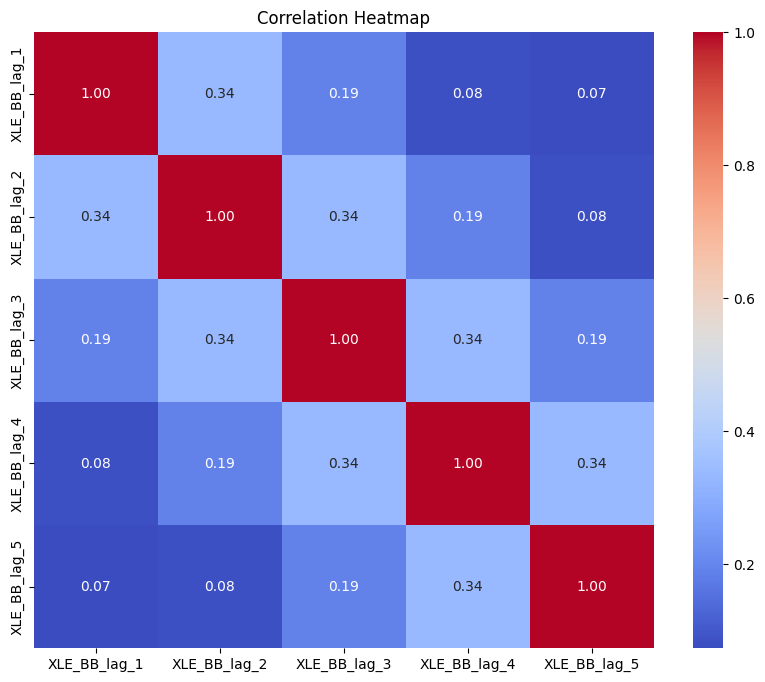

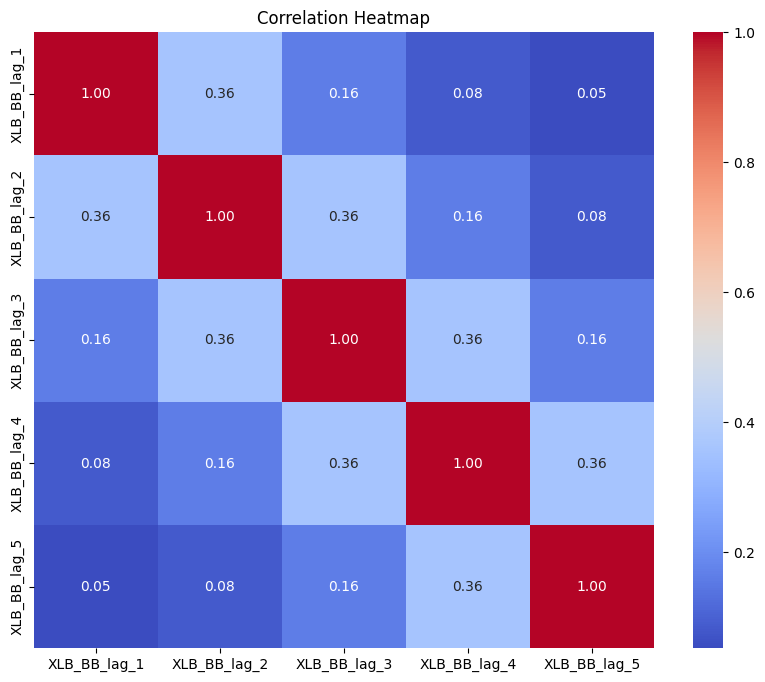

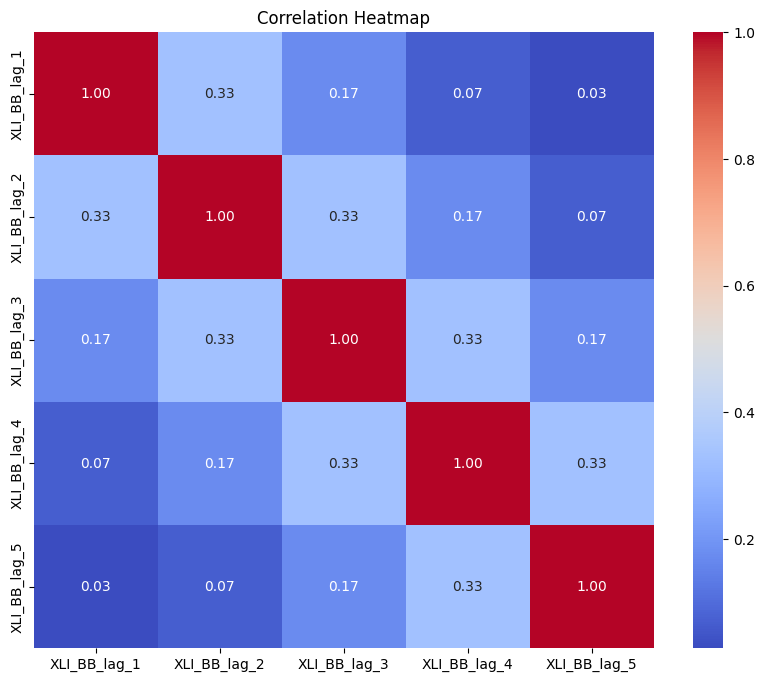

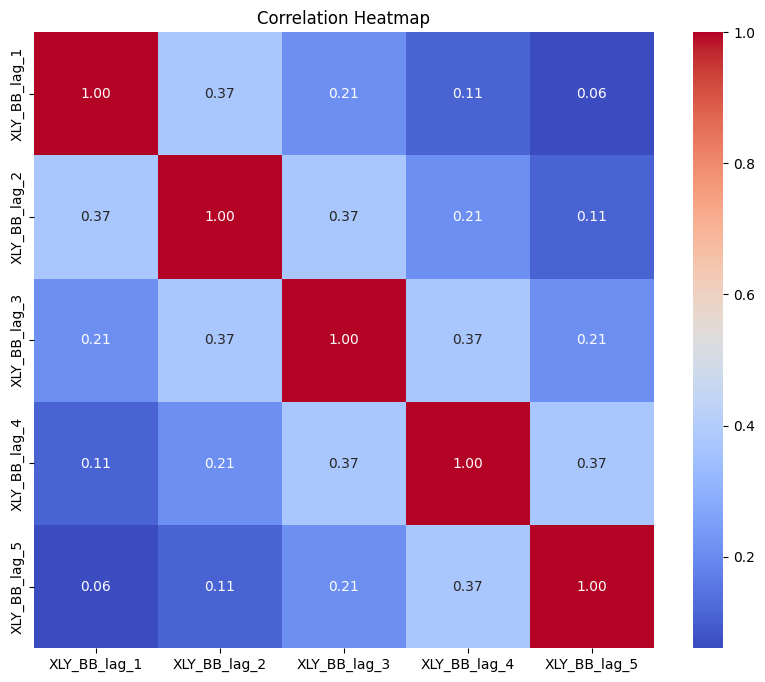

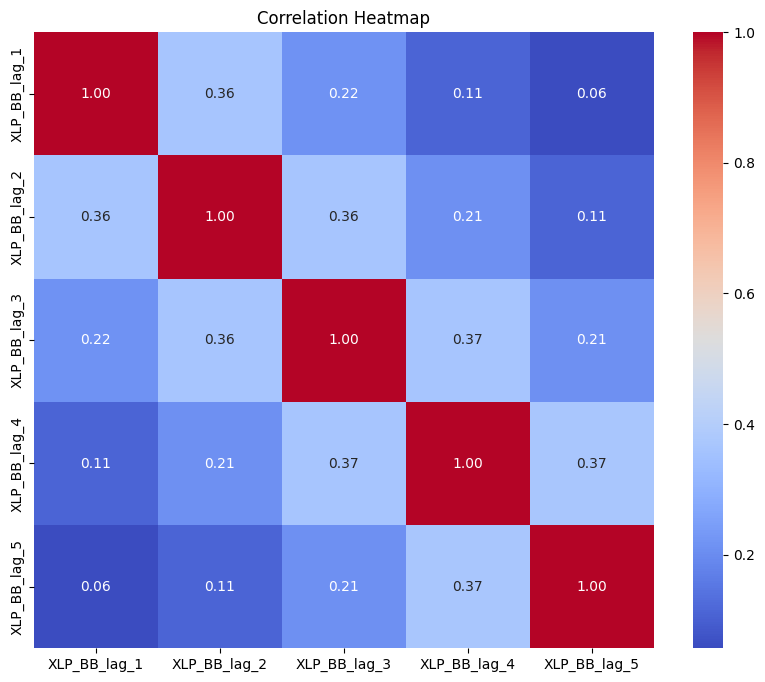

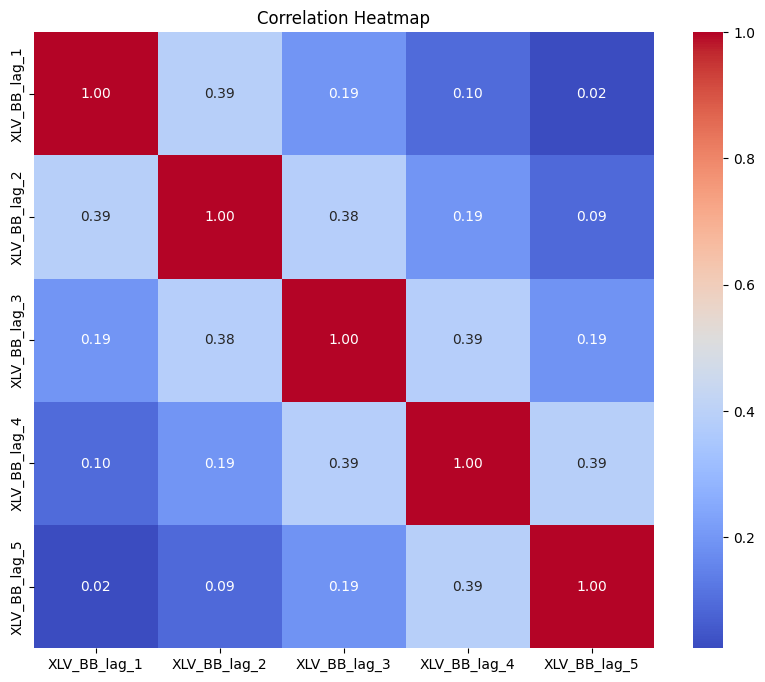

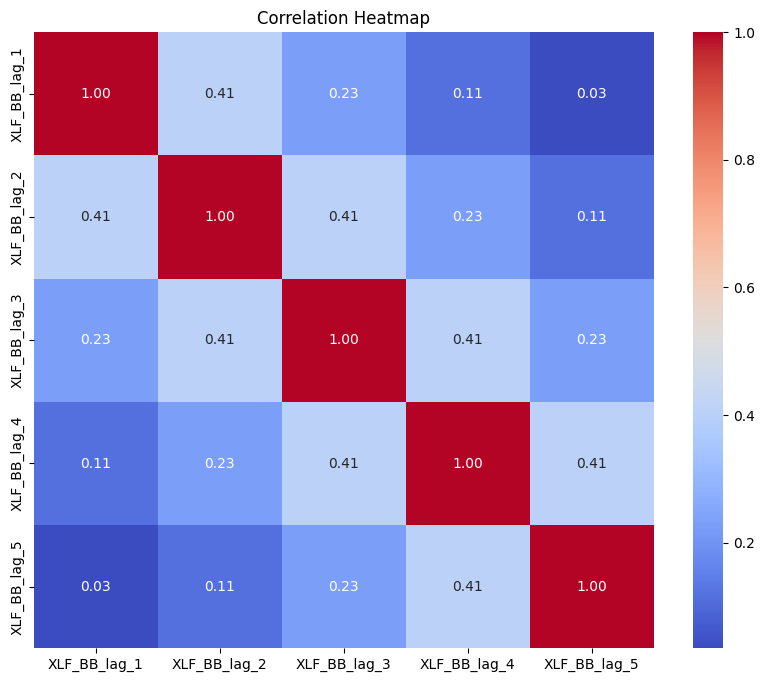

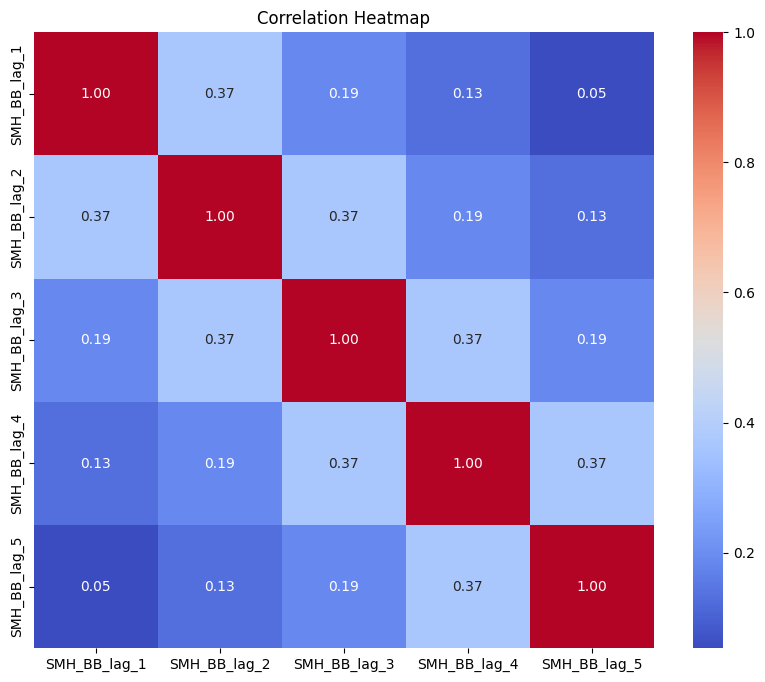

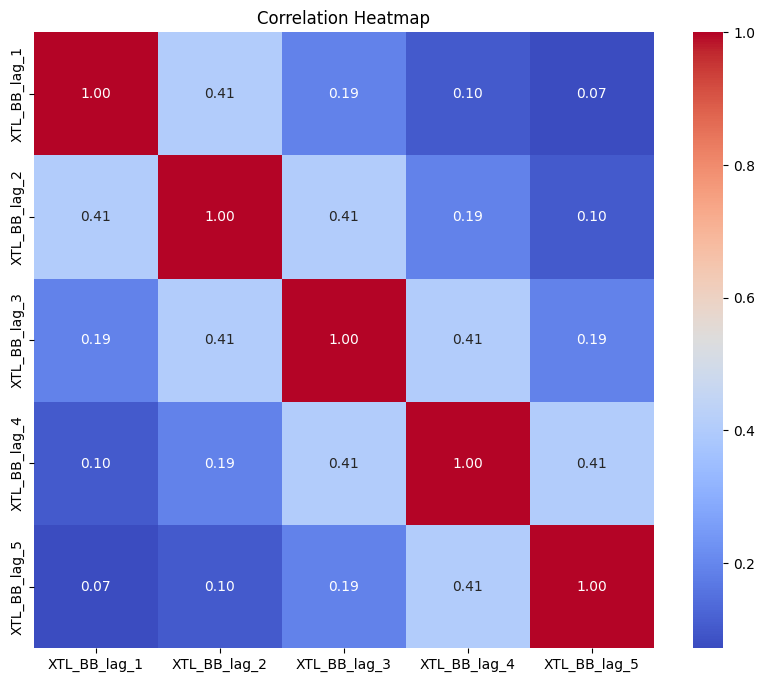

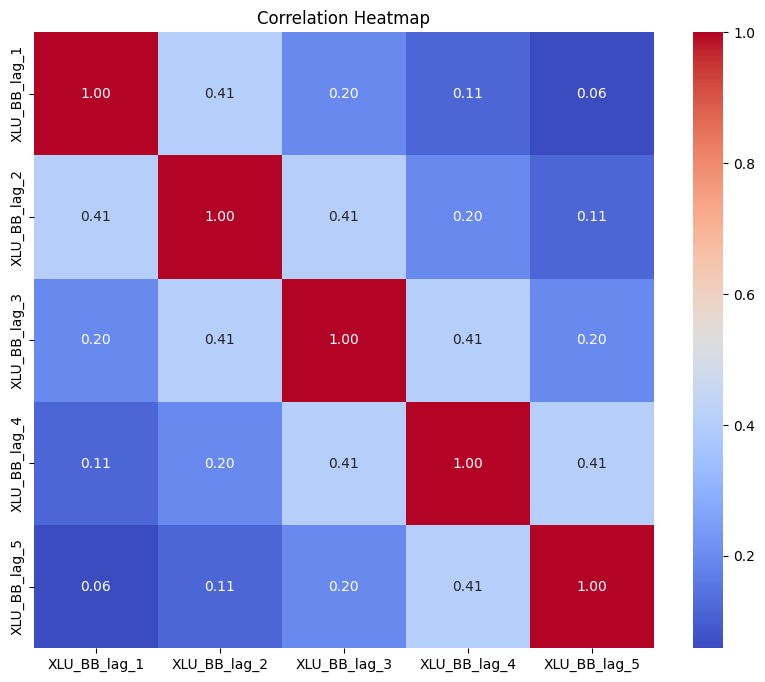

In [ ]:
for asset in columns:
    LAG_CORR(data, asset, lag=5, TI = 'BB')

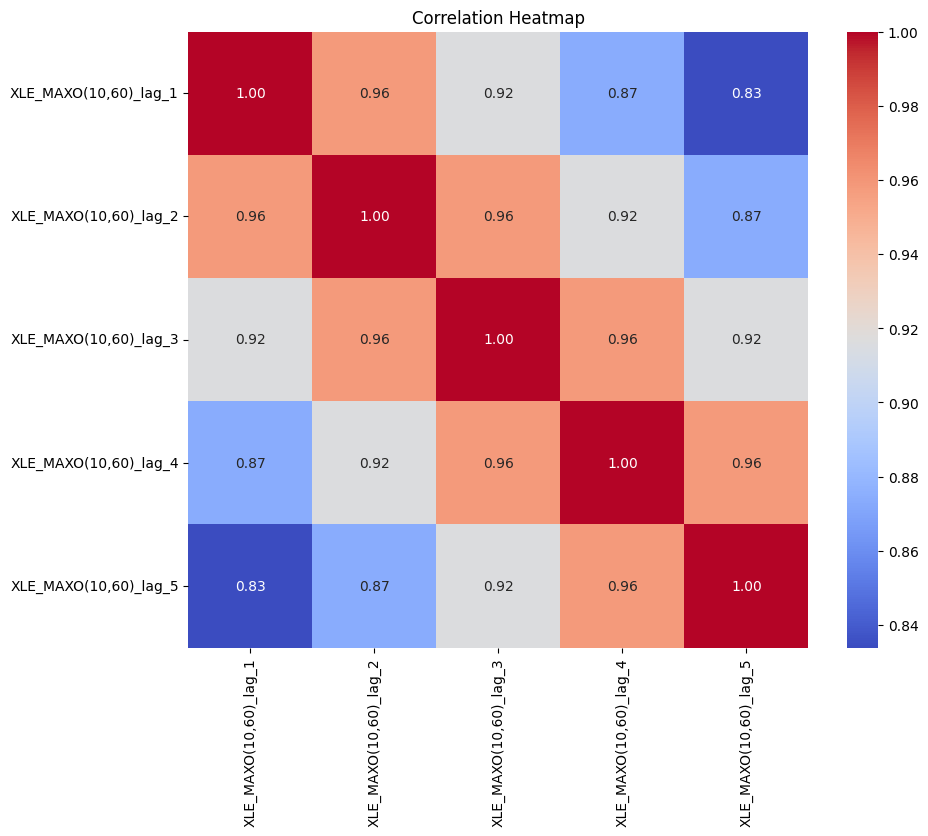

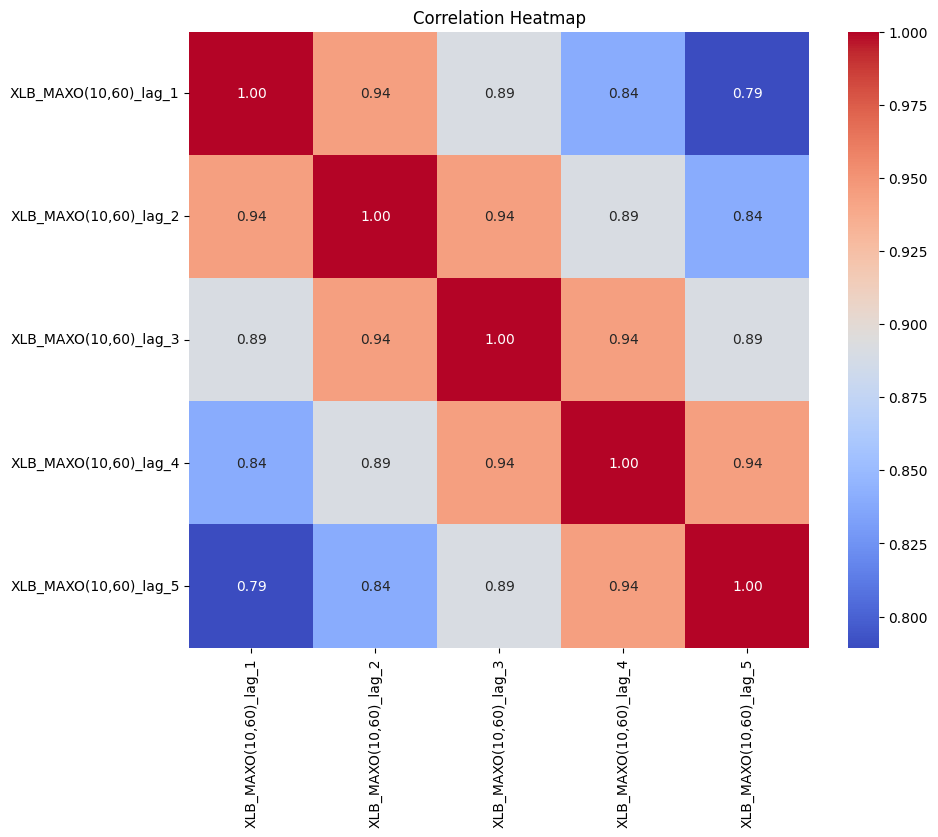

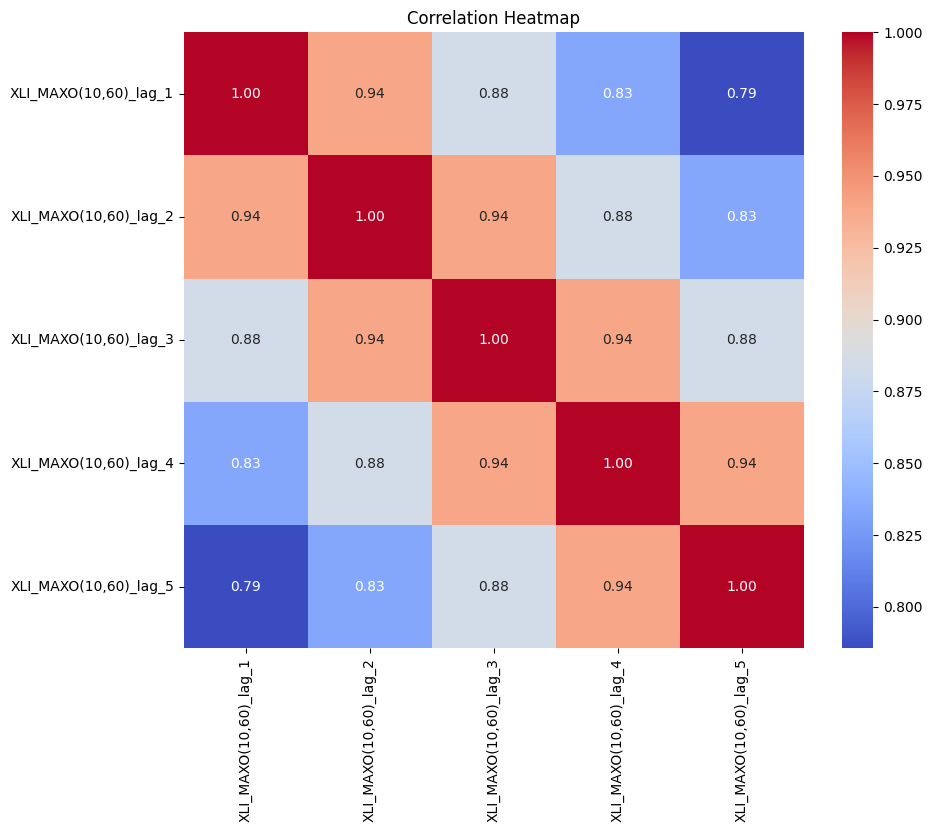

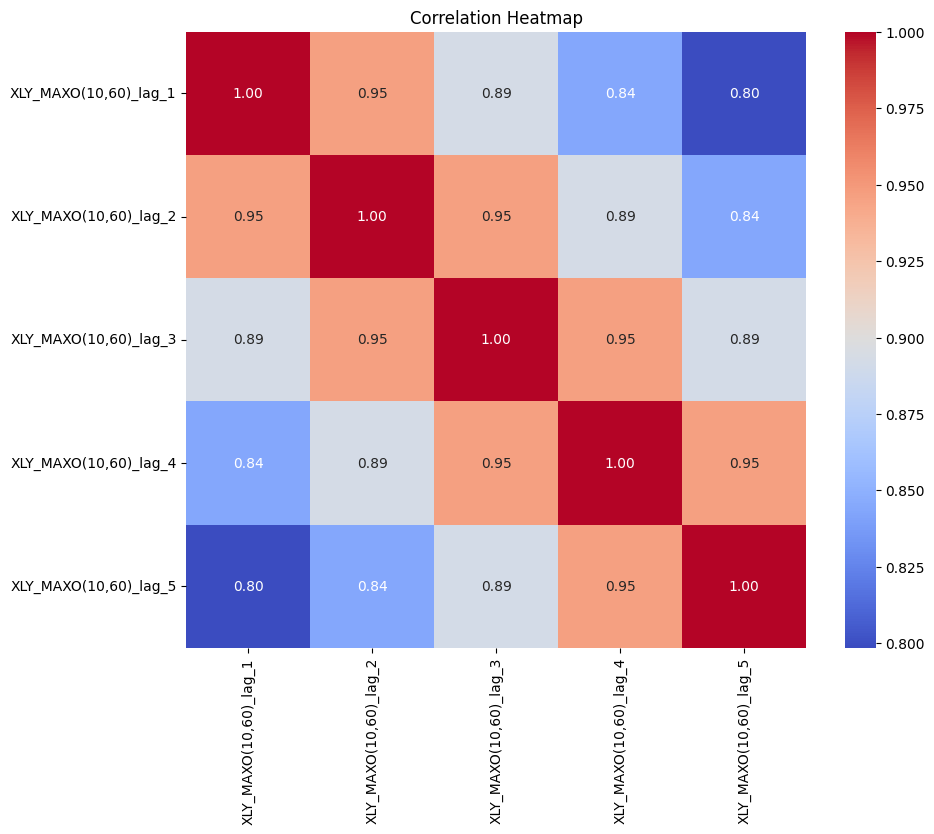

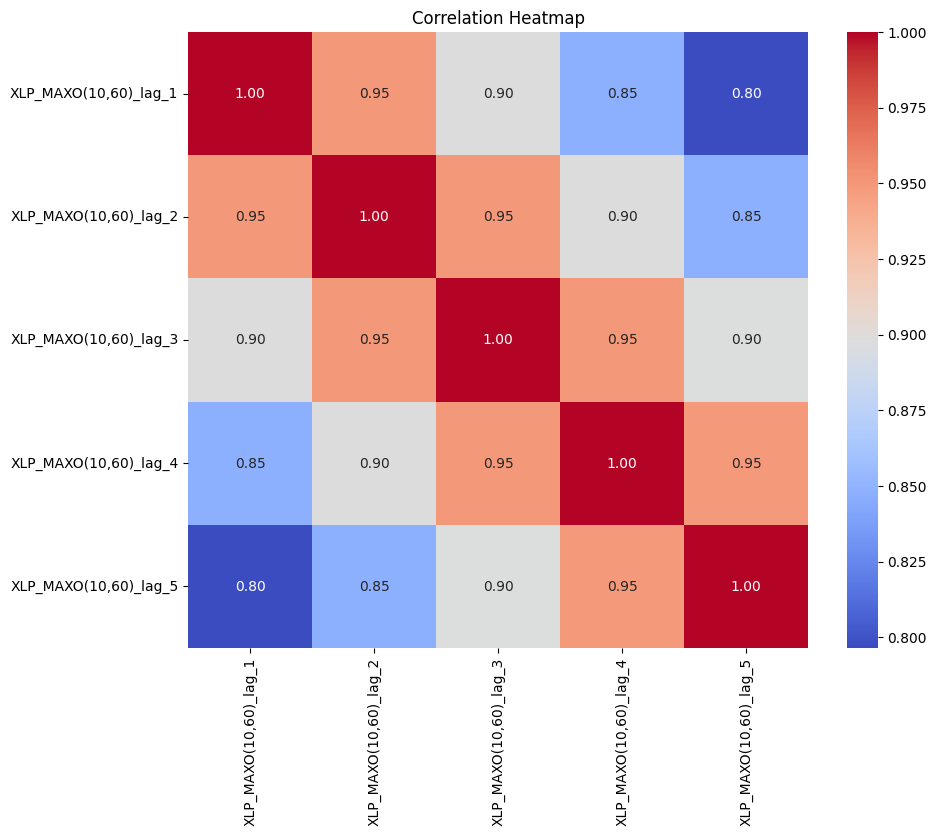

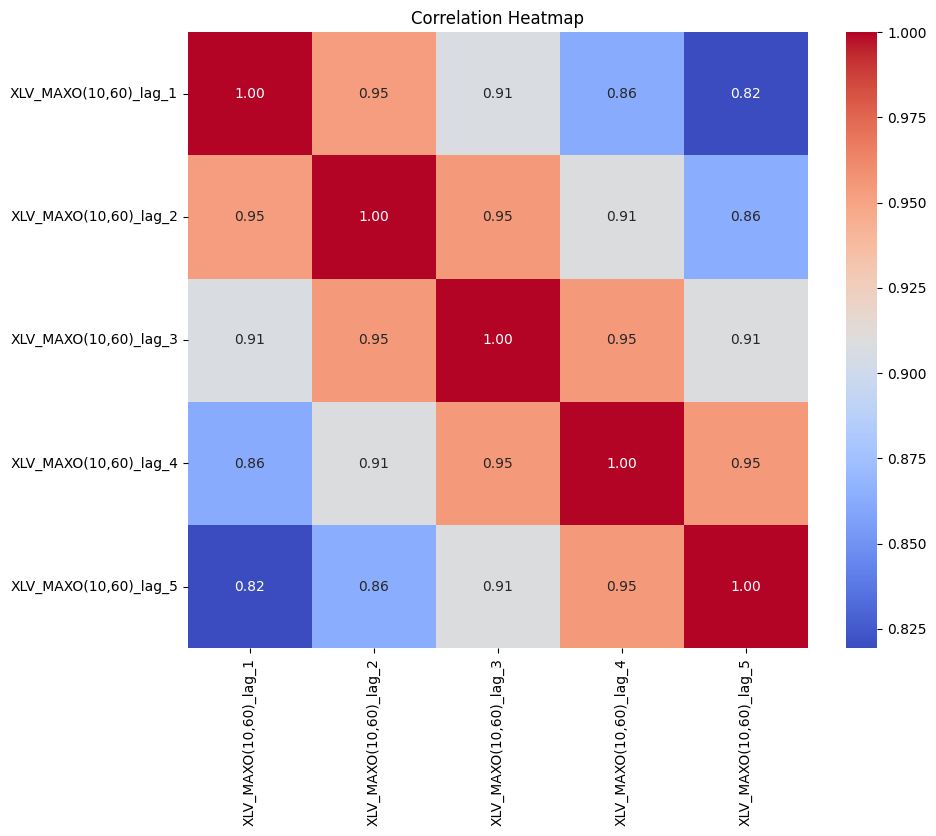

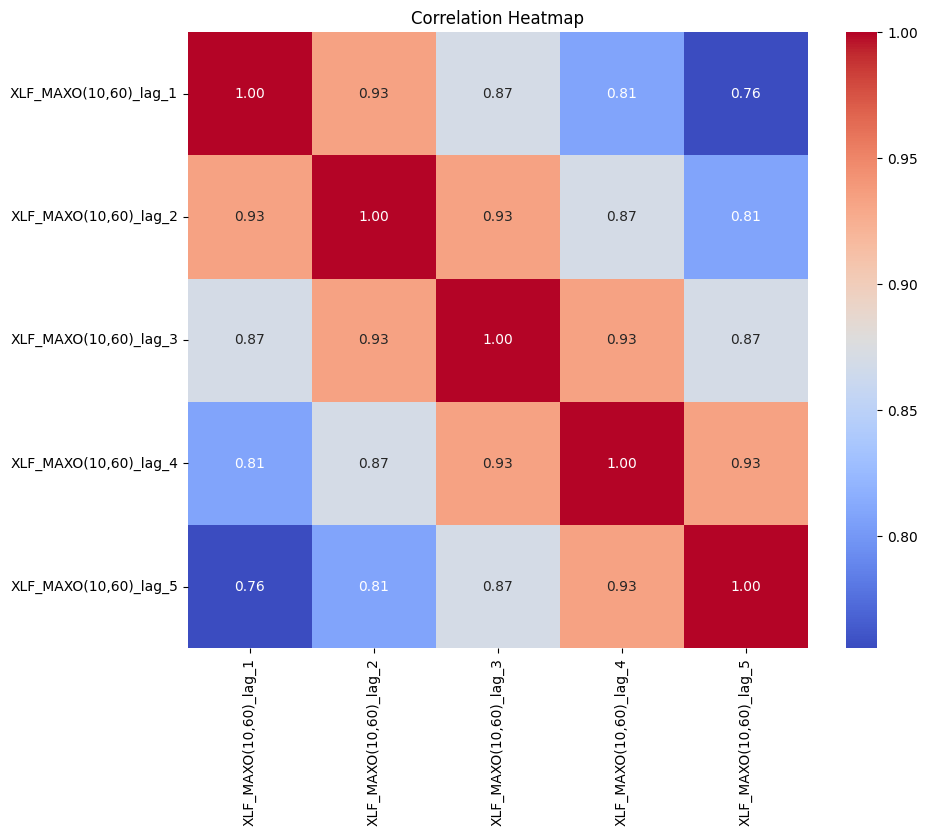

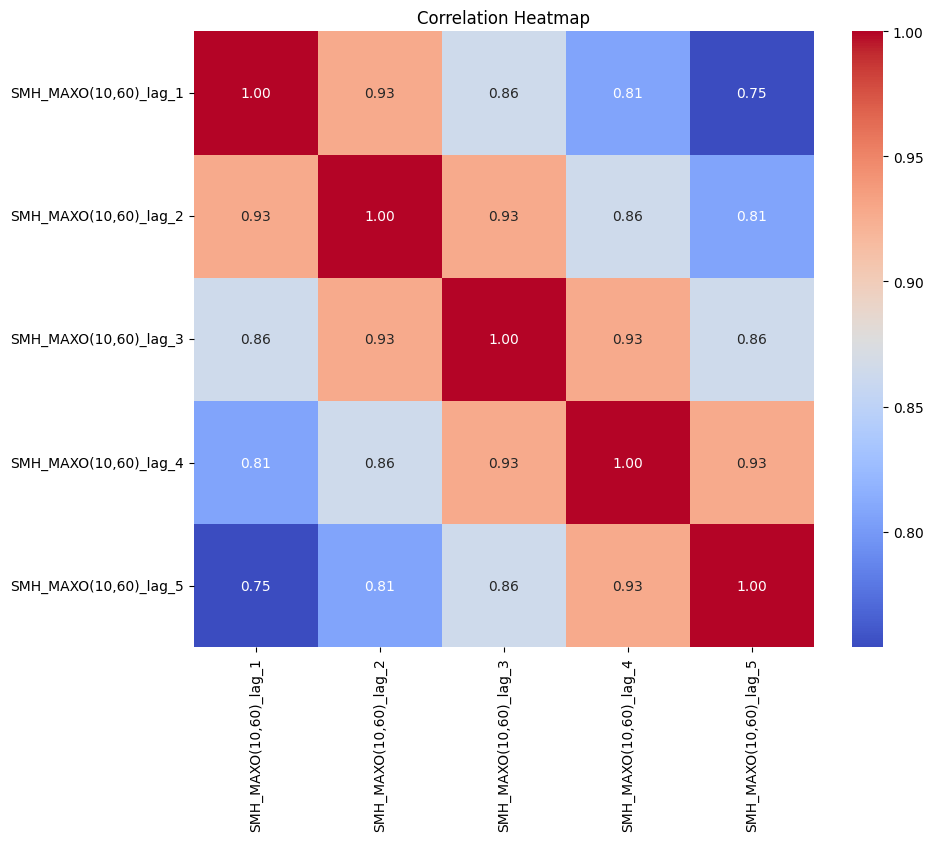

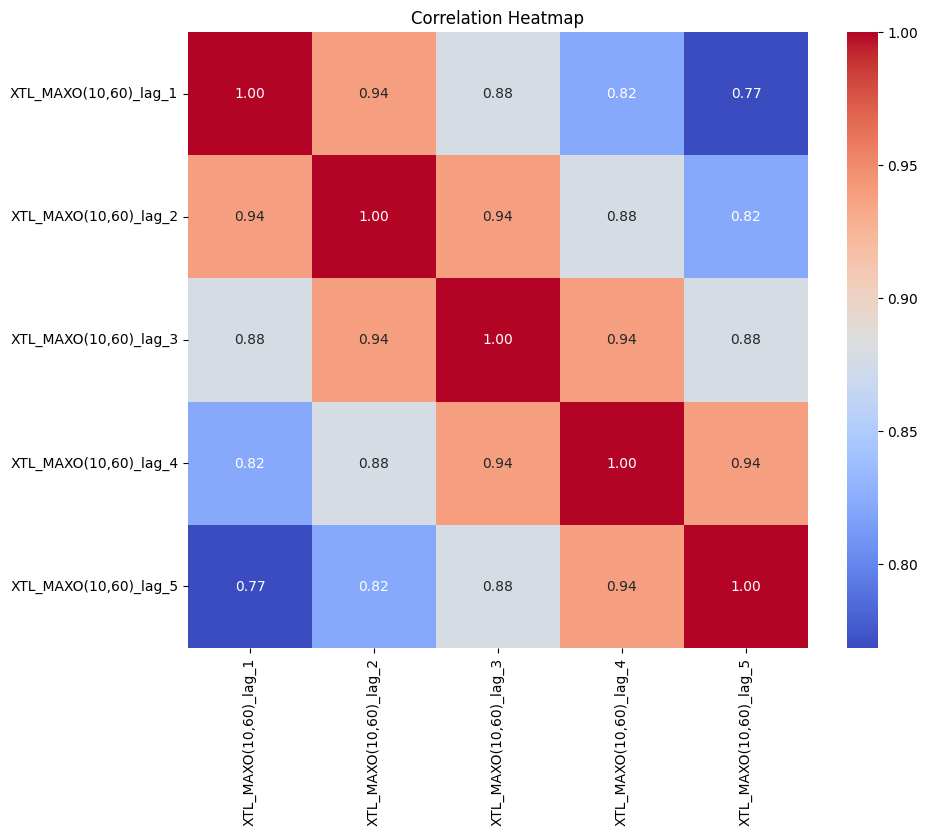

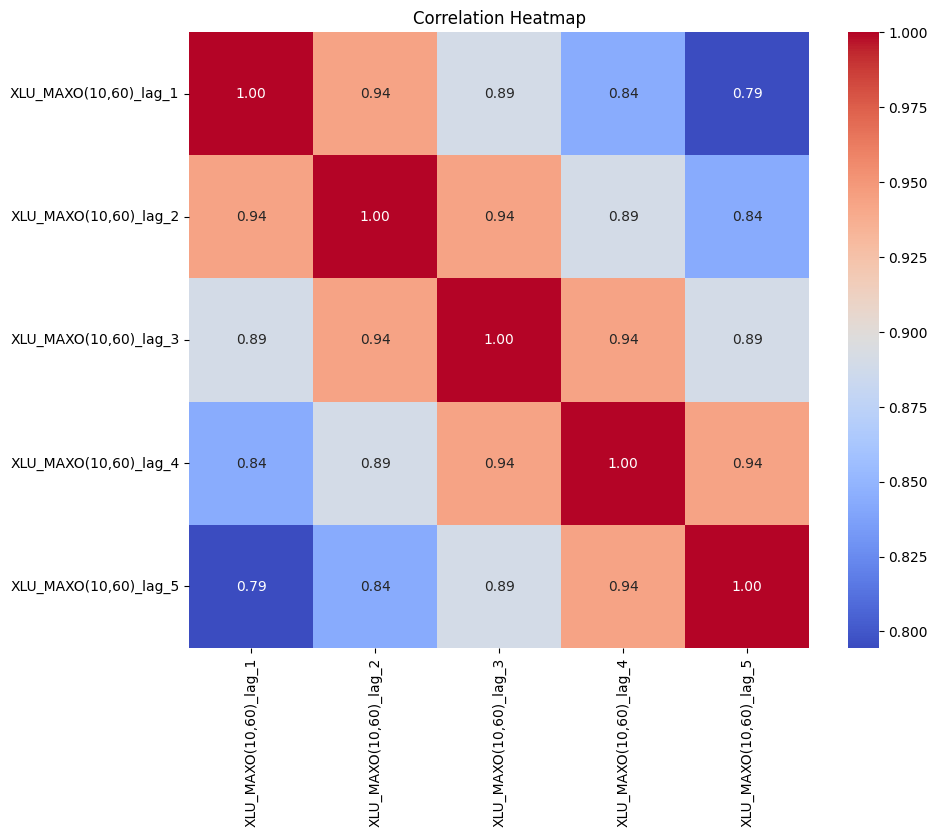

In [ ]:
for asset in columns:
    LAG_CORR(data, asset, lag=5, TI = 'MAXO(10,60)')

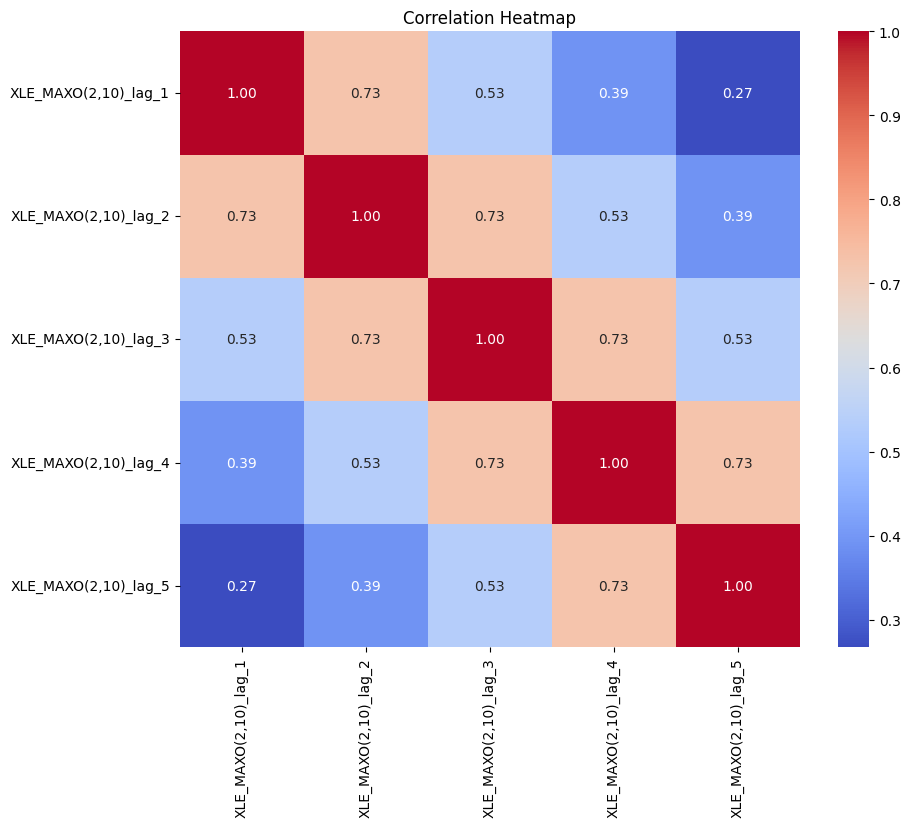

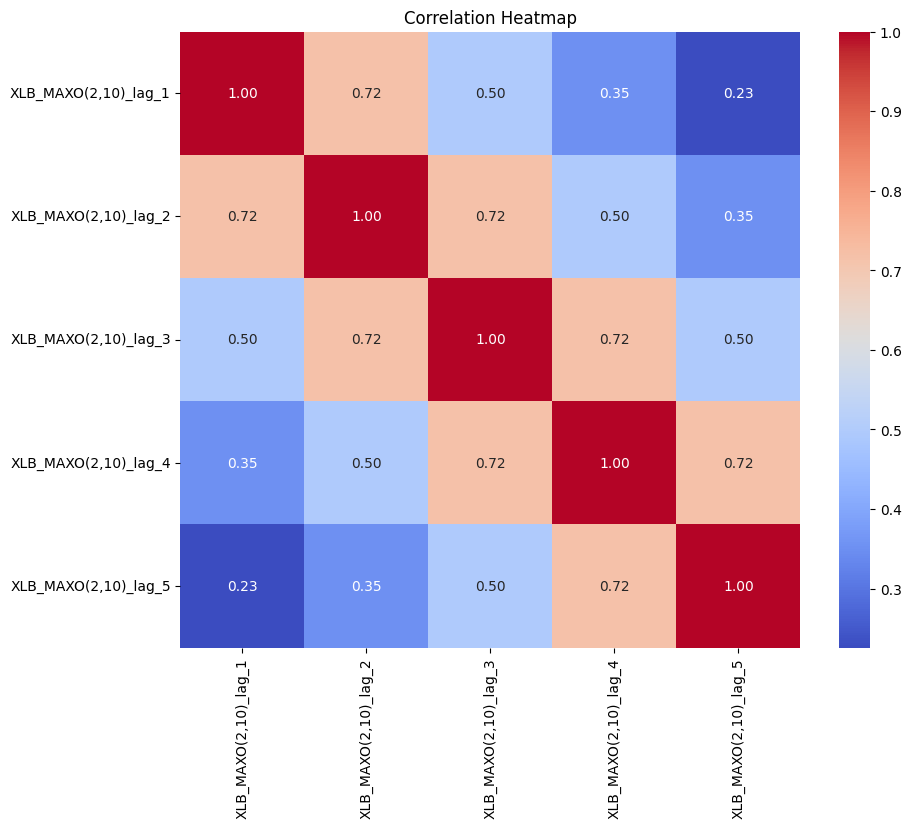

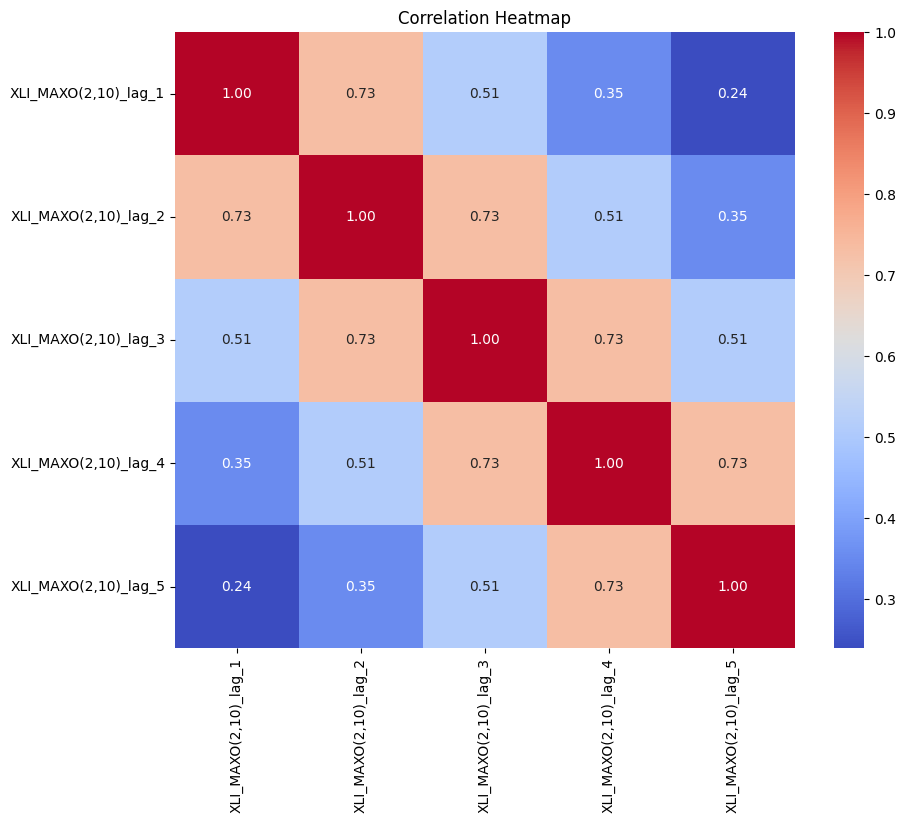

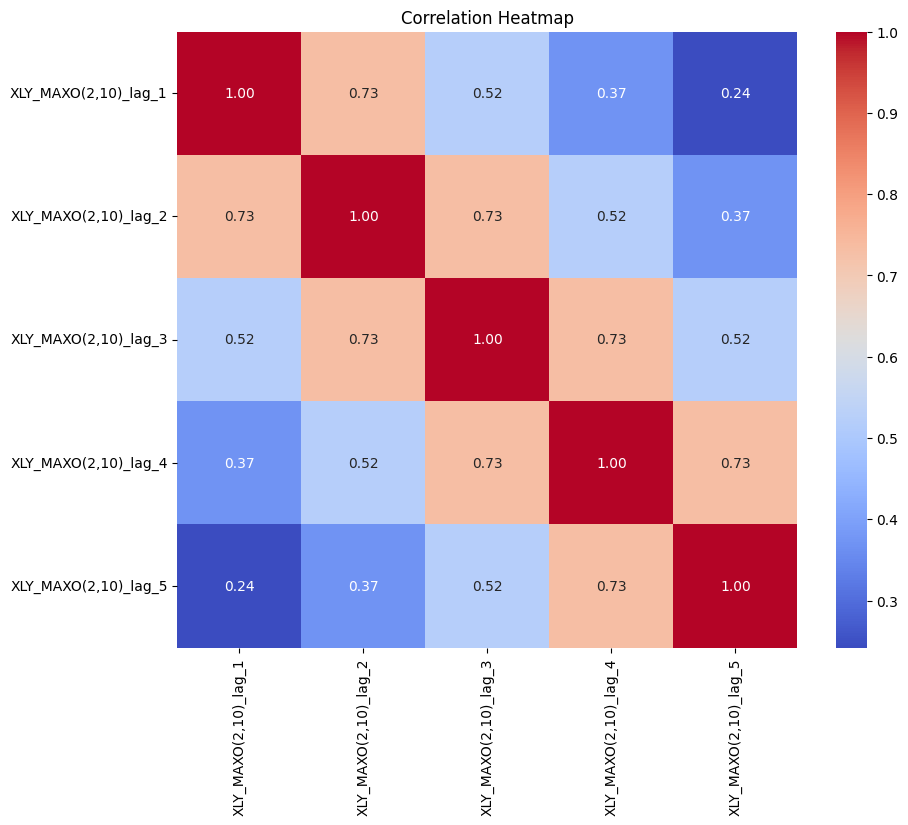

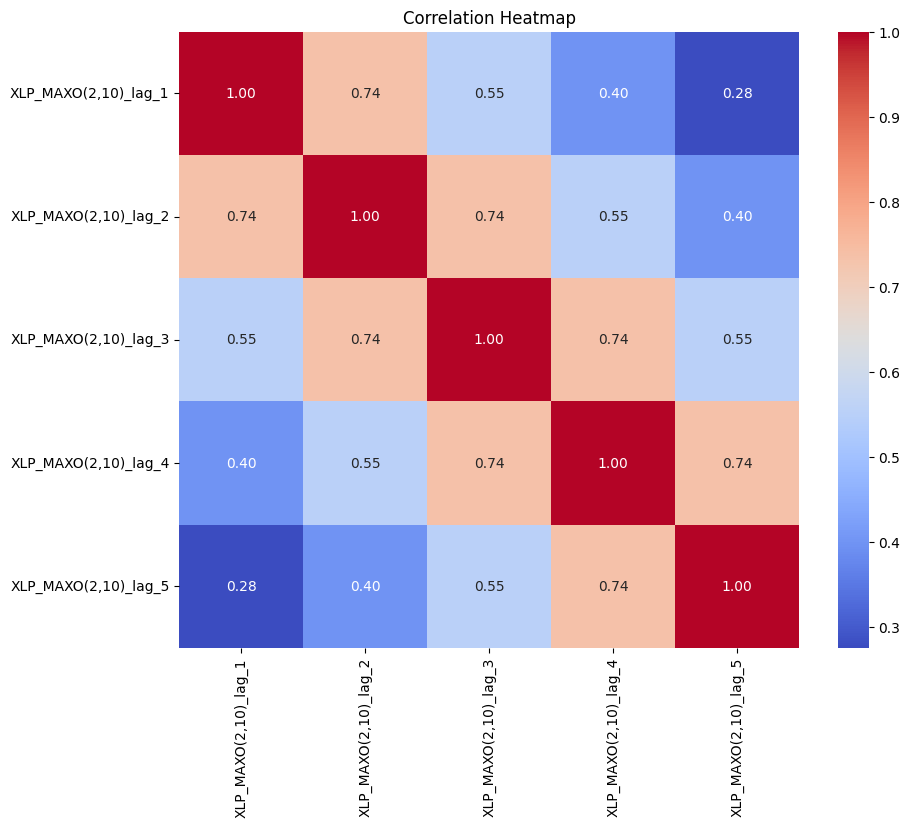

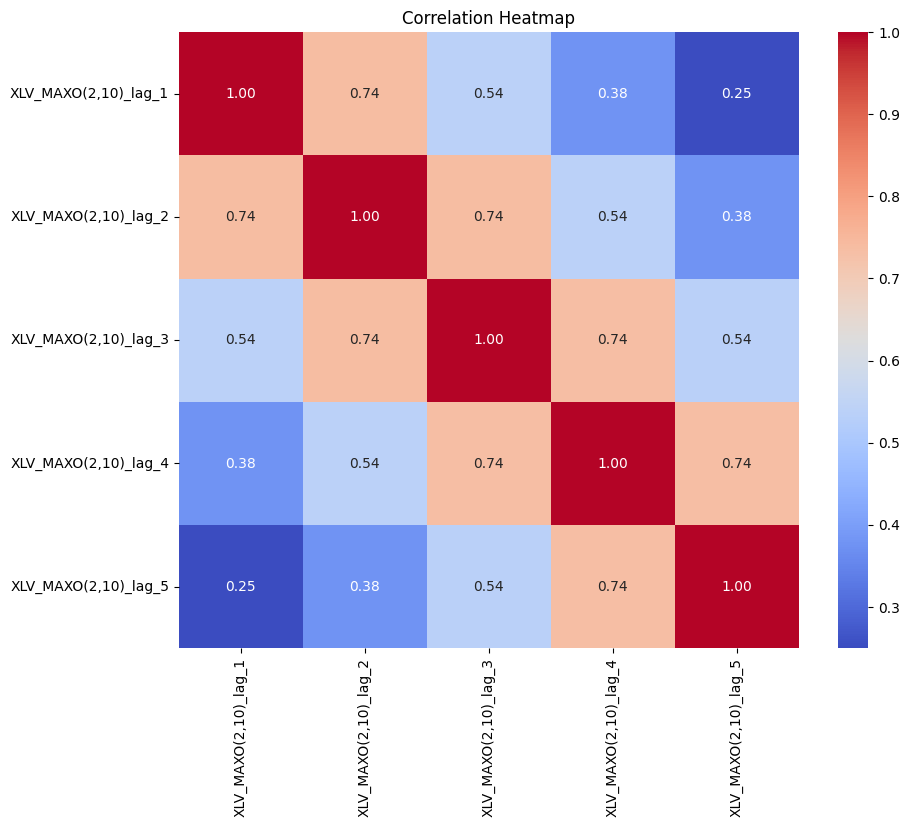

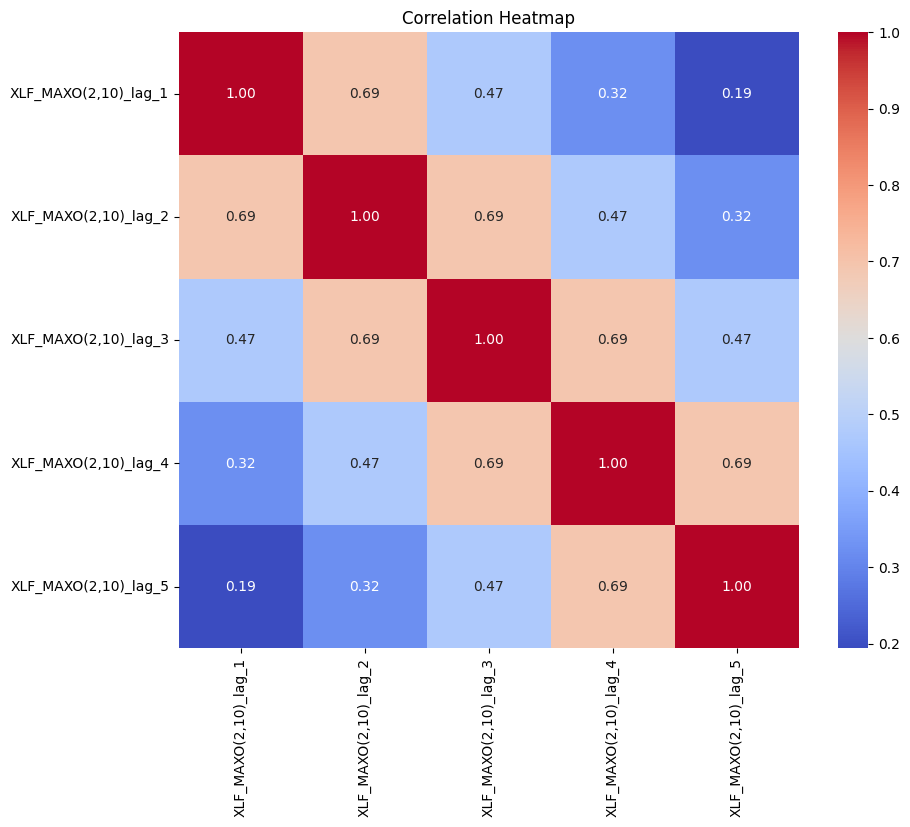

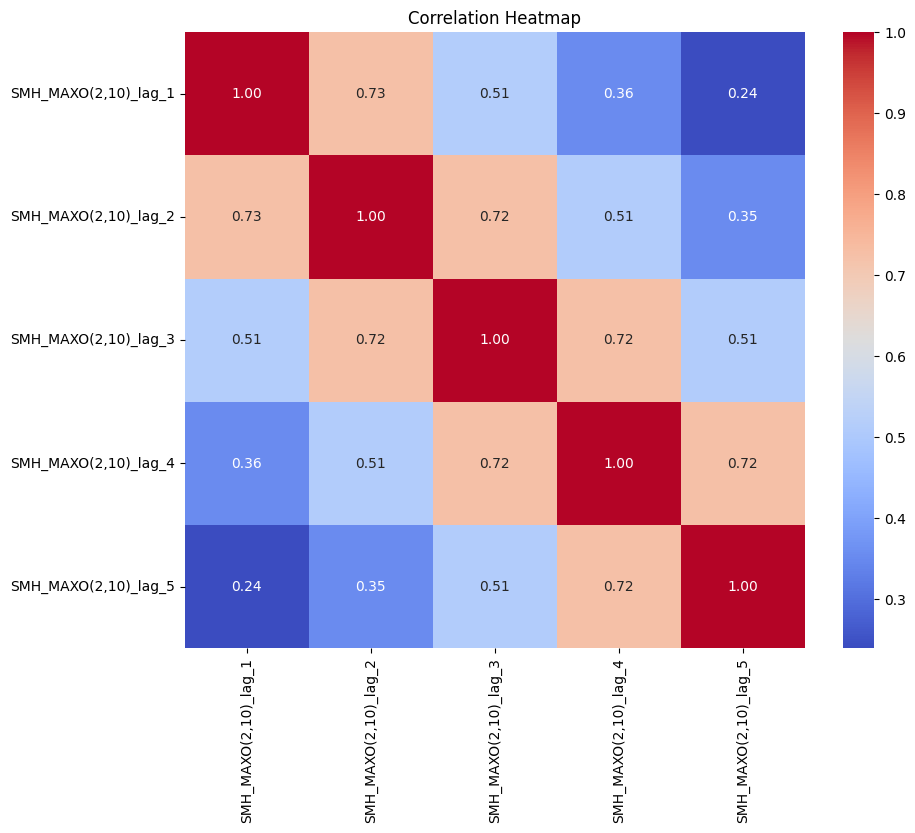

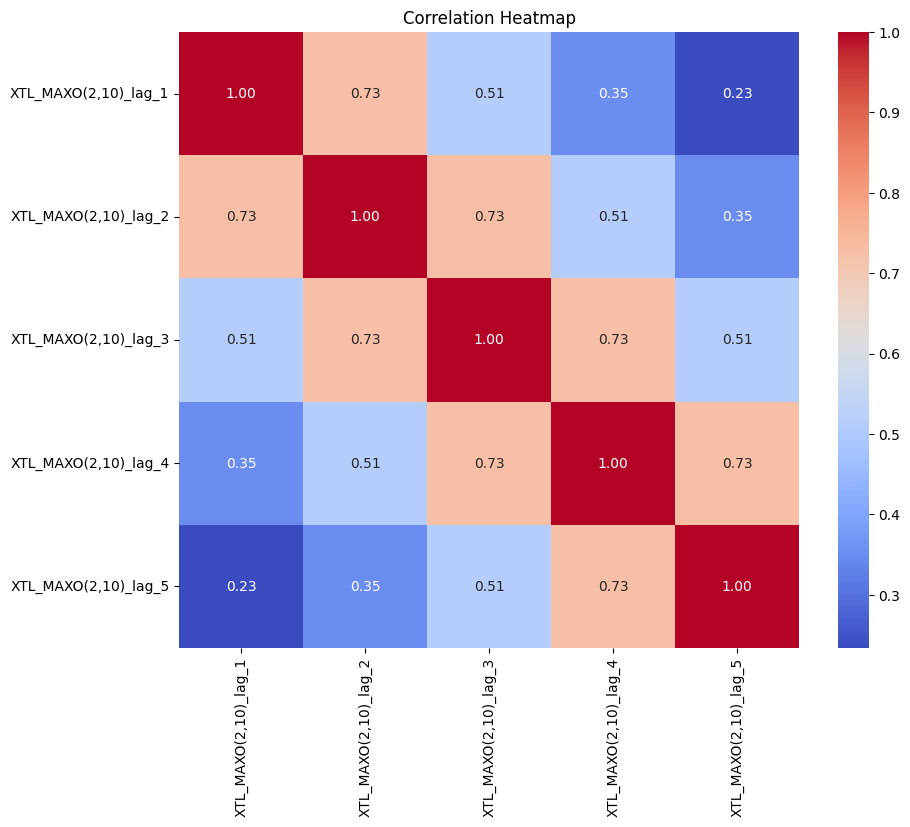

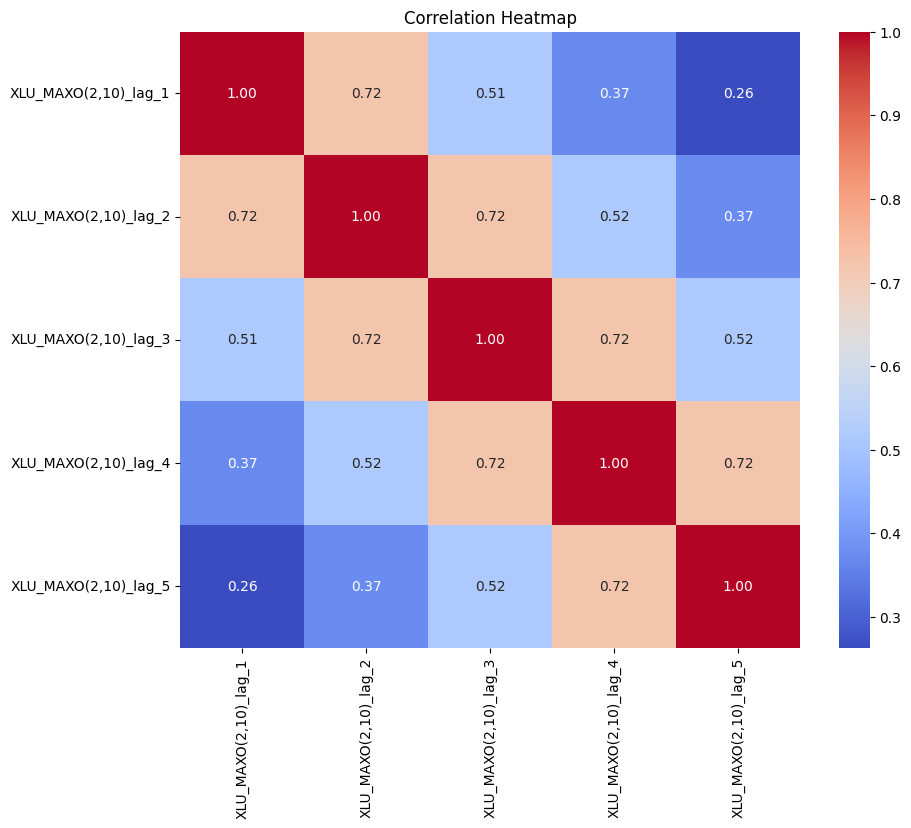

In [ ]:
for asset in columns:
    LAG_CORR(data, asset, lag=5, TI = 'MAXO(2,10)')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data = data.fillna(data.mean())
df_with_const = add_constant(data)

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

print(vif_data)

                 Variable         VIF
0                   const  488.873395
1                     XLE    6.742363
2                     XLB  144.684248
3                     XLI  442.257190
4                     XLY  155.851464
..                    ...         ...
198  XLU_MAXO(2,10)_lag_1    3.630933
199  XLU_MAXO(2,10)_lag_2    3.615616
200  XLU_MAXO(2,10)_lag_3    3.659637
201  XLU_MAXO(2,10)_lag_4    3.665221
202  XLU_MAXO(2,10)_lag_5    2.547790

[203 rows x 2 columns]


In [ ]:
high_vif = vif_data[vif_data["VIF"] > 10]

for index, row in high_vif.iterrows():
    print(row['Variable'])

const
XLB
XLI
XLY
XLP
XLV
XLF
SMH
XTL
XLU
bb_hband
bb_lband
XLE_MAXO(10,60)
XLB_MAXO(10,60)
XLI_MAXO(10,60)
XLY_MAXO(10,60)
XLP_MAXO(10,60)
XLV_MAXO(10,60)
XTL_MAXO(10,60)
XLU_MAXO(10,60)
XLE_MAXO(10,60)_lag_1
XLE_MAXO(10,60)_lag_2
XLE_MAXO(10,60)_lag_3
XLE_MAXO(10,60)_lag_4
XLE_MAXO(10,60)_lag_5
XLB_MAXO(10,60)_lag_1
XLB_MAXO(10,60)_lag_2
XLB_MAXO(10,60)_lag_3
XLB_MAXO(10,60)_lag_4
XLB_MAXO(10,60)_lag_5
XLI_MAXO(10,60)_lag_1
XLI_MAXO(10,60)_lag_2
XLI_MAXO(10,60)_lag_3
XLI_MAXO(10,60)_lag_4
XLI_MAXO(10,60)_lag_5
XLY_MAXO(10,60)_lag_1
XLY_MAXO(10,60)_lag_2
XLY_MAXO(10,60)_lag_3
XLY_MAXO(10,60)_lag_4
XLY_MAXO(10,60)_lag_5
XLP_MAXO(10,60)_lag_1
XLP_MAXO(10,60)_lag_2
XLP_MAXO(10,60)_lag_3
XLP_MAXO(10,60)_lag_4
XLP_MAXO(10,60)_lag_5
XLV_MAXO(10,60)_lag_1
XLV_MAXO(10,60)_lag_2
XLV_MAXO(10,60)_lag_3
XLV_MAXO(10,60)_lag_4
XLV_MAXO(10,60)_lag_5
XLF_MAXO(10,60)_lag_1
XLF_MAXO(10,60)_lag_2
XLF_MAXO(10,60)_lag_3
XLF_MAXO(10,60)_lag_4
SMH_MAXO(10,60)_lag_1
SMH_MAXO(10,60)_lag_2
SMH_MAXO(10,60)_lag_

That's why we delete MAXO(10,60) signals: most of its VIF value > 10, showing high multicollinearity and could be candidates for removal or adjustment.

In [ ]:
def OLS(data, asset, TI):
    predictor_columns = [col for col in data.columns if col.startswith(f'{asset}_{TI}')]

    X = data[predictor_columns]
    y = data[f'{asset}_return']

    X = X.dropna()
    y = y.loc[X.index]

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    return model

In [ ]:

  X = data['XLE_BB']
  y = data[f'{asset}_return']

  X = X.dropna()
  y = y.loc[X.index]

  X = sm.add_constant(X)

  model = sm.OLS(y, X).fit()
  print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             XLU_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.146
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.143
Time:                        05:25:27   Log-Likelihood:                 6415.1
No. Observations:                1905   AIC:                        -1.283e+04
Df Residuals:                    1903   BIC:                        -1.282e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.094      0.0

In [ ]:
models_BB = {}

for asset in columns:
    models_BB[asset] = OLS(data, asset, TI = 'BB')

for asset, model_BB in models_BB.items():
    print(f"Model Summary for {asset}:")
    print(model_BB.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6898
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.658
Time:                        05:25:27   Log-Likelihood:                 5686.6
No. Observations:                1905   AIC:                        -1.136e+04
Df Residuals:                    1898   BIC:                        -1.132e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001  

In [ ]:
from statsmodels.stats.stattools import durbin_watson

results = []
for asset, model_BB in models_BB.items():
    durbin_watson_stat = durbin_watson(model_BB.resid)

    results.append({
        'Asset': asset,
        'BB Coefficient': model_BB.params[1],
        'BB t-statistic': model_BB.tvalues[1],
        'Durbin-Watson': durbin_watson_stat
    })
results_df = pd.DataFrame(results)

csv_file_path = 'results_BB.csv'
results_df.to_csv(csv_file_path, index=False)

results_df



Asset  BB Coefficient  BB t-statistic  Durbin-Watson
0   XLE        0.001430        1.530898       1.947819
1   XLB       -0.000743       -0.954329       1.982962
2   XLI        0.000265        0.365814       1.961600
3   XLY        0.000120        0.168298       1.977340
4   XLP        0.000646        1.235741       1.980214
5   XLV       -0.000688       -1.004390       2.011528
6   XLF       -0.001347       -1.717854       2.059620
7   SMH        0.001459        1.417038       2.041103
8   XTL       -0.001278       -1.557176       2.001006
9   XLU        0.000538        0.830056       1.998225

In [ ]:
# average_r_squared = results['R^2 of BB models'].mean()

# print("Average R^2:", average_r_squared)

In [ ]:
models_MAXO = {}

for asset in columns:
    models_MAXO[asset] = OLS(data, asset, TI = 'MAXO(2,10)')

for asset, model_MAXO in models_MAXO.items():
    print(f"Model Summary for {asset}:")
    print(model_MAXO.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4274
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.861
Time:                        05:25:28   Log-Likelihood:                 5685.8
No. Observations:                1905   AIC:                        -1.136e+04
Df Residuals:                    1898   BIC:                        -1.132e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

In [ ]:
results = []
for asset, model_MAXO in models_MAXO.items():
    durbin_watson_stat = durbin_watson(model_MAXO.resid)

    results.append({
        'Asset': asset,
        'BB Coefficient': model_MAXO.params[1],
        'BB t-statistic': model_MAXO.tvalues[1],
        'Durbin-Watson': durbin_watson_stat
    })
results_df = pd.DataFrame(results)

csv_file_path = 'results_MAXO.csv'
results_df.to_csv(csv_file_path, index=False)

results_df



Asset  BB Coefficient  BB t-statistic  Durbin-Watson
0   XLE        0.000456        1.107548       1.992799
1   XLB       -0.000052       -0.154703       1.957357
2   XLI        0.000339        1.075325       1.978766
3   XLY        0.000286        0.928217       1.991467
4   XLP        0.000011        0.043655       2.009957
5   XLV        0.000336        1.089424       2.000408
6   XLF       -0.000191       -0.578936       2.010340
7   SMH        0.000429        0.956849       2.074112
8   XTL        0.000028        0.080121       1.971042
9   XLU       -0.000057       -0.203773       2.012190

## Reisudals without VIX

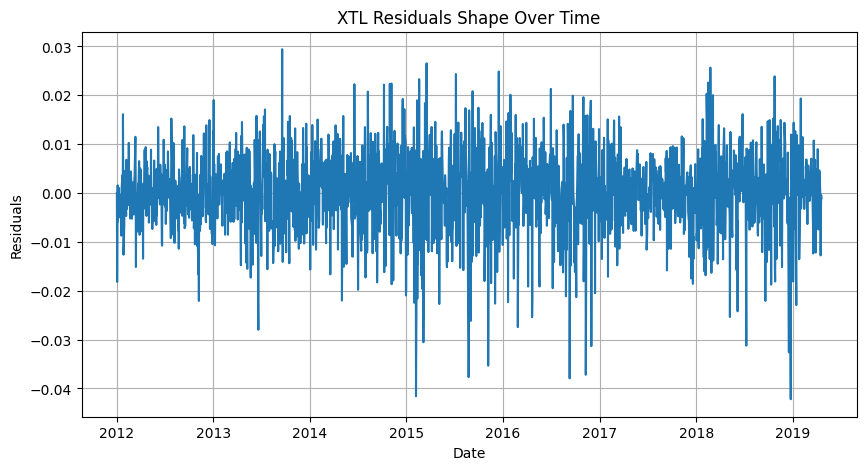

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model_BB.resid.index, model_BB.resid)
plt.title('XTL Residuals Shape Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

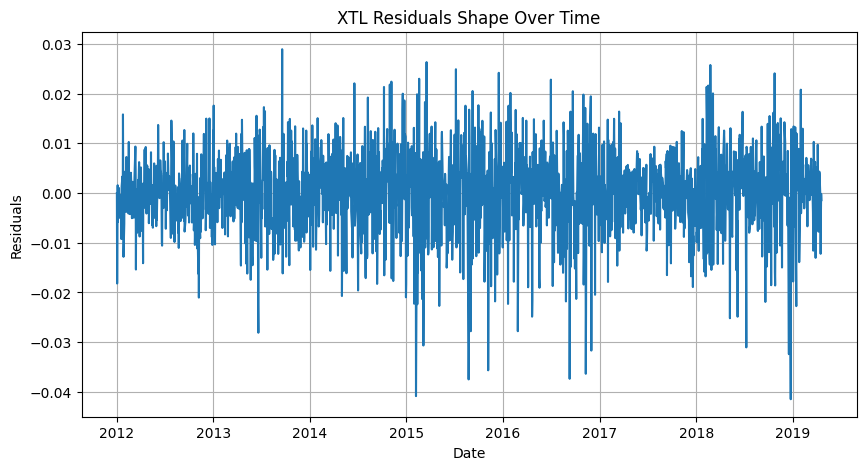

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model_MAXO.resid.index, model_MAXO.resid)
plt.title('XTL Residuals Shape Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

## include VIX

In [ ]:
vix = pd.read_csv('VIXCLS.csv')
vix['VIXCLS'] = pd.to_numeric(vix['VIXCLS'], errors='coerce')

# vix['volatility'] = vix['VIXCLS'].shift(1).expanding().std().fillna(method='bfill') # Or another method, e.g., fillna(vix['volatility'].mean(), inplace=True)
vix['volatility'] = vix['VIXCLS'].shift(1).expanding().std()

vix.dropna(subset=['VIXCLS'], inplace=True)
vix.rename(columns={'DATE': 'Date'}, inplace=True)

vix['Date'] = pd.to_datetime(vix['Date'])

if isinstance(data.index, pd.DatetimeIndex):
    data.reset_index(inplace=True)

all_data = pd.merge(data, vix, on='Date')
all_data = all_data.set_index('Date')
all_data

XLE      XLB      XLI       XLY      XLP       XLV      XLF  \
Date                                                                          
2012-01-03  71.0500  34.4300  34.4900   39.3500  32.4600   35.1400  10.8323   
2012-01-04  71.2000  34.7200  34.6500   39.6600  32.3900   34.9700  10.7998   
2012-01-05  70.8600  34.8200  34.6600   39.9900  32.3700   35.0700  10.9460   
2012-01-06  70.4400  34.7700  34.5900   40.0500  32.1600   35.1300  10.8770   
2012-01-09  70.7800  34.8400  34.8450   39.9900  32.2100   35.1900  10.9338   
...             ...      ...      ...       ...      ...       ...      ...   
2019-04-12  81.1002  67.5045  89.6697  131.3203  68.1949  100.9396  30.9321   
2019-04-15  80.6200  67.1909  89.1708  131.5867  68.5953  101.3442  30.7383   
2019-04-16  81.1482  67.4929  89.7161  132.1638  68.6074   99.2649  31.1714   
2019-04-17  81.0402  67.0747  89.8322  132.4191  68.9472   96.4101  31.2512   
2019-04-18  80.6560  67.1560  90.8649  132.3747  69.0079   96.5675  31.1600   

                SMH      XTL      XLU  ...  XTL_MAXO(2,10)_lag_3  \
Date                                   ...                         
2012-01-03  15.4250  42.9999  35.3400  ...              0.139535   
2012-01-04  15.4350  41.8620  35.1400  ...              0.139535   
2012-01-05  15.6250  41.6700  35.2100  ...              0.139535   
2012-01-06  15.6050  41.6395  35.0200  ...              0.139535   
2012-01-09  15.8600  42.5000  35.0700  ...              0.139535   
...             ...      ...      ...  ...                   ...   
2019-04-12  63.6203  83.4902  75.3240  ...              1.000000   
2019-04-15  63.1623  83.1141  75.3111  ...              1.000000   
2019-04-16  64.7038  83.6465  74.3794  ...              1.000000   
2019-04-17  65.6588  82.8107  74.0947  ...              1.000000   
2019-04-18  65.7538  82.8681  74.1335  ...              1.000000   

            XTL_MAXO(2,10)_lag_4  XTL_MAXO(2,10)_lag_5  XLU_MAXO(2,10)_lag_1  \
Date                                                                           
2012-01-03               0.13908              0.138624               0.17793   
2012-01-04               0.13908              0.138624               0.17793   
2012-01-05               0.13908              0.138624               0.17793   
2012-01-06               0.13908              0.138624               0.17793   
2012-01-09               0.13908              0.138624               0.17793   
...                          ...                   ...                   ...   
2019-04-12               1.00000              1.000000              -1.00000   
2019-04-15               1.00000              1.000000              -1.00000   
2019-04-16               1.00000              1.000000               1.00000   
2019-04-17               1.00000              1.000000               1.00000   
2019-04-18               1.00000              1.000000              -1.00000   

            XLU_MAXO(2,10)_lag_2  XLU_MAXO(2,10)_lag_3  XLU_MAXO(2,10)_lag_4  \
Date                                                                           
2012-01-03              0.178553              0.179175              0.178741   
2012-01-04              0.178553              0.179175              0.178741   
2012-01-05              0.178553              0.179175              0.178741   
2012-01-06              0.178553              0.179175              0.178741   
2012-01-09              0.178553              0.179175              0.178741   
...                          ...                   ...                   ...   
2019-04-12             -1.000000             -1.000000             -1.000000   
2019-04-15             -1.000000             -1.000000             -1.000000   
2019-04-16             -1.000000             -1.000000             -1.000000   
2019-04-17              1.000000             -1.000000             -1.000000   
2019-04-18              1.000000              1.000000             -1.000000   

            XLU_MAXO(

In [ ]:
all_data = all_data.dropna()
all_data

XLE      XLB      XLI       XLY      XLP       XLV      XLF  \
Date                                                                          
2012-01-05  70.8600  34.8200  34.6600   39.9900  32.3700   35.0700  10.9460   
2012-01-06  70.4400  34.7700  34.5900   40.0500  32.1600   35.1300  10.8770   
2012-01-09  70.7800  34.8400  34.8450   39.9900  32.2100   35.1900  10.9338   
2012-01-10  71.4100  35.4900  35.3500   40.2500  32.3200   35.4500  11.1328   
2012-01-11  70.4500  35.8350  35.4600   40.3100  32.1800   35.4800  11.2586   
...             ...      ...      ...       ...      ...       ...      ...   
2019-04-12  81.1002  67.5045  89.6697  131.3203  68.1949  100.9396  30.9321   
2019-04-15  80.6200  67.1909  89.1708  131.5867  68.5953  101.3442  30.7383   
2019-04-16  81.1482  67.4929  89.7161  132.1638  68.6074   99.2649  31.1714   
2019-04-17  81.0402  67.0747  89.8322  132.4191  68.9472   96.4101  31.2512   
2019-04-18  80.6560  67.1560  90.8649  132.3747  69.0079   96.5675  31.1600   

                SMH      XTL      XLU  ...  XTL_MAXO(2,10)_lag_3  \
Date                                   ...                         
2012-01-05  15.6250  41.6700  35.2100  ...              0.139535   
2012-01-06  15.6050  41.6395  35.0200  ...              0.139535   
2012-01-09  15.8600  42.5000  35.0700  ...              0.139535   
2012-01-10  15.9750  43.0000  35.1200  ...              0.139535   
2012-01-11  15.9550  43.1300  34.9600  ...              0.139535   
...             ...      ...      ...  ...                   ...   
2019-04-12  63.6203  83.4902  75.3240  ...              1.000000   
2019-04-15  63.1623  83.1141  75.3111  ...              1.000000   
2019-04-16  64.7038  83.6465  74.3794  ...              1.000000   
2019-04-17  65.6588  82.8107  74.0947  ...              1.000000   
2019-04-18  65.7538  82.8681  74.1335  ...              1.000000   

            XTL_MAXO(2,10)_lag_4  XTL_MAXO(2,10)_lag_5  XLU_MAXO(2,10)_lag_1  \
Date                                                                           
2012-01-05               0.13908              0.138624               0.17793   
2012-01-06               0.13908              0.138624               0.17793   
2012-01-09               0.13908              0.138624               0.17793   
2012-01-10               0.13908              0.138624               0.17793   
2012-01-11               0.13908              0.138624               0.17793   
...                          ...                   ...                   ...   
2019-04-12               1.00000              1.000000              -1.00000   
2019-04-15               1.00000              1.000000              -1.00000   
2019-04-16               1.00000              1.000000               1.00000   
2019-04-17               1.00000              1.000000               1.00000   
2019-04-18               1.00000              1.000000              -1.00000   

            XLU_MAXO(2,10)_lag_2  XLU_MAXO(2,10)_lag_3  XLU_MAXO(2,10)_lag_4  \
Date                                                                           
2012-01-05              0.178553              0.179175              0.178741   
2012-01-06              0.178553              0.179175              0.178741   
2012-01-09              0.178553              0.179175              0.178741   
2012-01-10              0.178553              0.179175              0.178741   
2012-01-11              0.178553              0.179175              0.178741   
...                          ...                   ...                   ...   
2019-04-12             -1.000000             -1.000000             -1.000000   
2019-04-15             -1.000000             -1.000000             -1.000000   
2019-04-16             -1.000000             -1.000000             -1.000000   
2019-04-17              1.000000             -1.000000             -1.000000   
2019-04-18              1.000000              1.000000             -1.000000   

            XLU_MAXO(

In [ ]:
def OLS_2(data, asset, TI):
  predictor_columns = [col for col in data.columns if col.startswith(f'{asset}_{TI}')]
  X = data[predictor_columns].div(data['volatility'], axis=0)
  y = data[f'{asset}_return'].div(data['volatility'], axis=0)
  y = pd.DataFrame(y, columns=[f'{asset}_return'])

  aligned_data = pd.concat([X, y], axis=1).dropna()

  X = aligned_data[predictor_columns]
  y = aligned_data[f'{asset}_return']

  X = sm.add_constant(X)

  model = sm.OLS(y, X).fit()

  return model

In [ ]:
models_2_BB = {}

for asset in columns:
    models_2_BB[asset] = OLS_2(all_data, asset, TI = 'BB')

for asset, model_2_BB in models_2_BB.items():
    print(f"Model Summary for {asset}:")
    print(model_2_BB.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9572
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.453
Time:                        05:25:29   Log-Likelihood:                 7483.8
No. Observations:                1833   AIC:                        -1.495e+04
Df Residuals:                    1826   BIC:                        -1.491e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.595e-05  

In [ ]:
results = []
for asset, model_2_BB in models_2_BB.items():
    durbin_watson_stat = durbin_watson(model_2_BB.resid)

    results.append({
        'Asset': asset,
        'intercept': model_2_BB.params[0],
        'Coefficient': model_2_BB.params[1],
        'lag_1 Coefficient': model_2_BB.params[2],
        'lag_2 Coefficient': model_2_BB.params[3],
        'lag_3 Coefficient': model_2_BB.params[4],
        'lag_4 Coefficient': model_2_BB.params[5],
        'lag_5 Coefficient': model_2_BB.params[6],
        't-statistic': model_2_BB.tvalues[1],
        'Durbin-Watson': durbin_watson_stat
    })
results_df = pd.DataFrame(results)

csv_file_path = 'results_BB_VIX.csv'
results_df.to_csv(csv_file_path, index=False)

results_df


Asset  intercept  Coefficient  lag_1 Coefficient  lag_2 Coefficient  \
0   XLE   0.000026     0.001858           0.000094          -0.000244   
1   XLB   0.000140    -0.000750           0.002320           0.000122   
2   XLI   0.000195     0.000276           0.001396           0.000797   
3   XLY   0.000254     0.000497           0.000095           0.001444   
4   XLP   0.000156     0.000761          -0.000198           0.000128   
5   XLV   0.000227    -0.000327           0.001218           0.000160   
6   XLF   0.000245    -0.001405           0.001295          -0.000260   
7   SMH   0.000315     0.001289           0.002368          -0.000888   
8   XTL   0.000160    -0.001821           0.002269           0.000593   
9   XLU   0.000133     0.000365           0.000614          -0.000688   

   lag_3 Coefficient  lag_4 Coefficient  lag_5 Coefficient  t-statistic  \
0          -0.000100           0.001062          -0.000402     1.966877   
1           0.000954           0.000787          -0.000378    -0.927302   
2          -0.000049           0.002174          -0.000798     0.360926   
3          -0.000130           0.000778          -0.001157     0.678007   
4           0.001235          -0.000568           0.000409     1.445481   
5           0.001294           0.000501          -0.000250    -0.480358   
6           0.000422           0.002630          -0.000916    -1.682296   
7           0.001455           0.000862          -0.001037     1.205574   
8          -0.000453           0.001444          -0.000770    -2.038509   
9          -0.000063          -0.001047           0.000317     0.553230   

   Durbin-Watson  
0       1.902306  
1       1.956881  
2       1.965719  
3       1.936123  
4       1.999593  
5       2.014263  
6       2.003054  
7       1.966194  
8       1.963050  
9       2.021098

In [ ]:
models_2_MAXO = {}

for asset in columns:
    models_2_MAXO[asset] = OLS_2(all_data, asset, TI = 'MAXO(2,10)')

for asset, model_2_MAXO in models_2_MAXO.items():
    print(f"Model Summary for {asset}:")
    print(model_2_MAXO.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7860
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.581
Time:                        05:25:29   Log-Likelihood:                 7483.3
No. Observations:                1833   AIC:                        -1.495e+04
Df Residuals:                    1826   BIC:                        -1.491e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

In [ ]:
results = []
for asset, model_2_MAXO in models_2_MAXO.items():
    durbin_watson_stat = durbin_watson(model_2_MAXO.resid)

    results.append({
        'Asset': asset,
        'intercept': model_2_MAXO.params[0],
        'Coefficient': model_2_MAXO.params[1],
        'lag_1 Coefficient': model_2_MAXO.params[2],
        'lag_2 Coefficient': model_2_MAXO.params[3],
        'lag_3 Coefficient': model_2_MAXO.params[4],
        'lag_4 Coefficient': model_2_MAXO.params[5],
        'lag_5 Coefficient': model_2_MAXO.params[6],
        't-statistic': model_2_MAXO.tvalues[1],
        'Durbin-Watson': durbin_watson_stat
    })
results_df = pd.DataFrame(results)

csv_file_path = 'results_MAXO_VIX.csv'
results_df.to_csv(csv_file_path, index=False)

results_df


Asset  intercept  Coefficient  lag_1 Coefficient  lag_2 Coefficient  \
0   XLE   0.000042     0.000552          -0.000705          -0.000349   
1   XLB   0.000179    -0.000100           0.000071          -0.000040   
2   XLI   0.000218     0.000281           0.000188          -0.000544   
3   XLY   0.000245     0.000316          -0.000429          -0.000013   
4   XLP   0.000159    -0.000089          -0.000229           0.000226   
5   XLV   0.000234     0.000131          -0.000337          -0.000030   
6   XLF   0.000235    -0.000324           0.000429          -0.000182   
7   SMH   0.000271     0.000554          -0.000674           0.000250   
8   XTL   0.000159     0.000097          -0.000009           0.000093   
9   XLU   0.000151    -0.000152          -0.000246           0.000174   

   lag_3 Coefficient  lag_4 Coefficient  lag_5 Coefficient  t-statistic  \
0           0.000107           0.000156           0.000004     1.323533   
1           0.000248          -0.001049           0.000306    -0.283838   
2          -0.000051          -0.000200           0.000055     0.864717   
3          -0.000258           0.000055           0.000416     1.005185   
4          -0.000400           0.000594          -0.000224    -0.371761   
5           0.000035          -0.000393           0.000341     0.434322   
6          -0.000192          -0.000484           0.000876    -0.928358   
7          -0.000041          -0.000690           0.001072     1.210727   
8           0.000191          -0.000574           0.000186     0.255233   
9          -0.000163           0.000605          -0.000486    -0.550463   

   Durbin-Watson  
0       1.962746  
1       1.935282  
2       1.984708  
3       1.968662  
4       2.029592  
5       2.003517  
6       1.951999  
7       2.000923  
8       1.928586  
9       2.027050

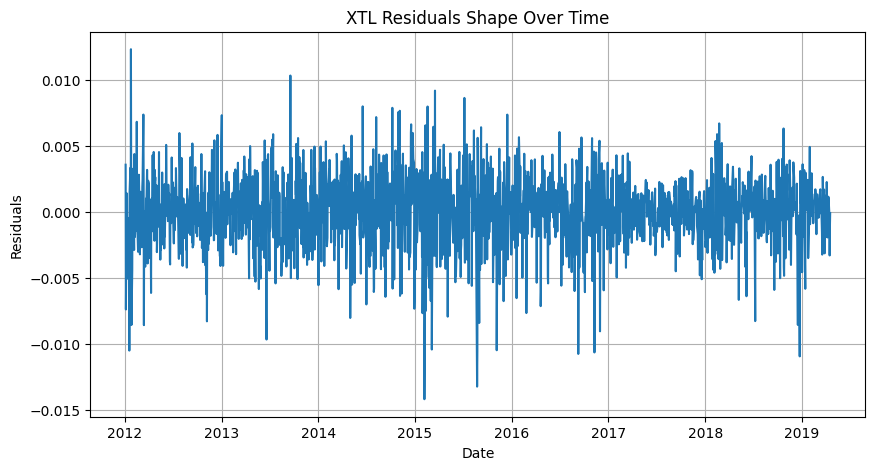

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model_2_BB.resid.index, model_2_BB.resid)
plt.title('XTL Residuals Shape Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

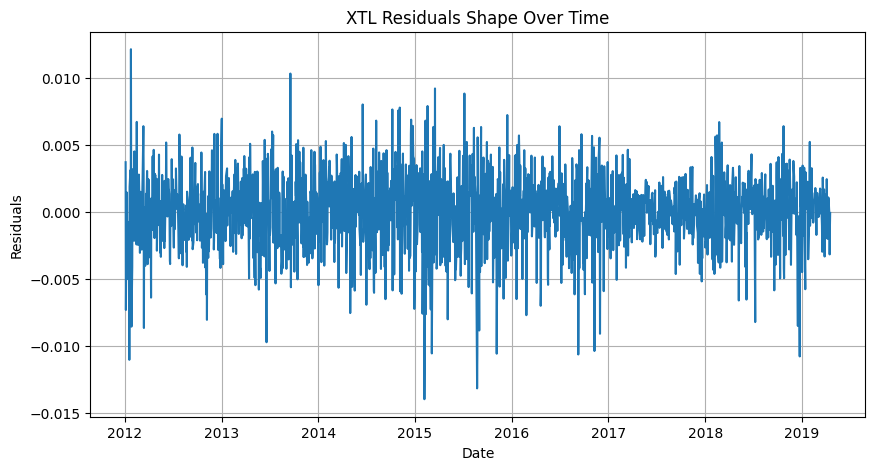

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model_2_MAXO.resid.index, model_2_MAXO.resid)
plt.title('XTL Residuals Shape Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

 ## Prediction WIth VIX

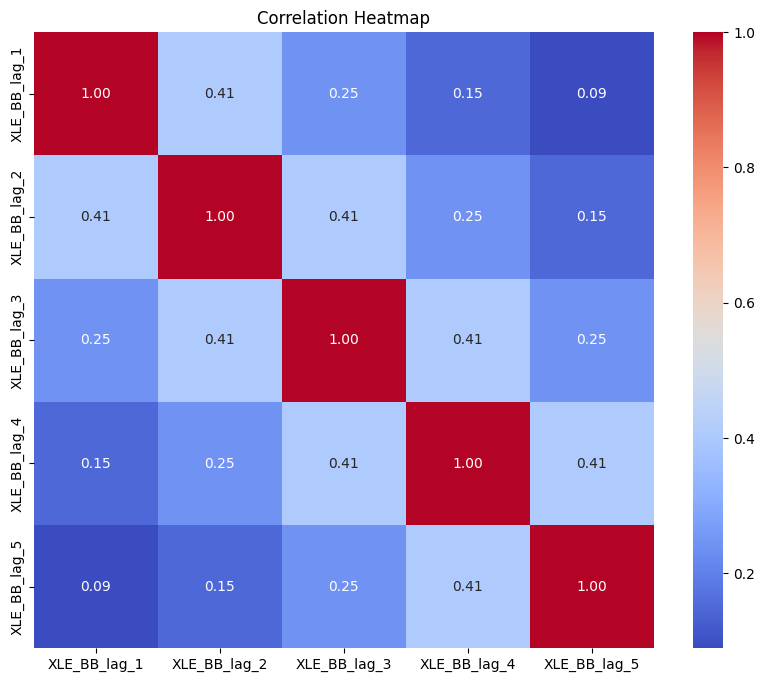

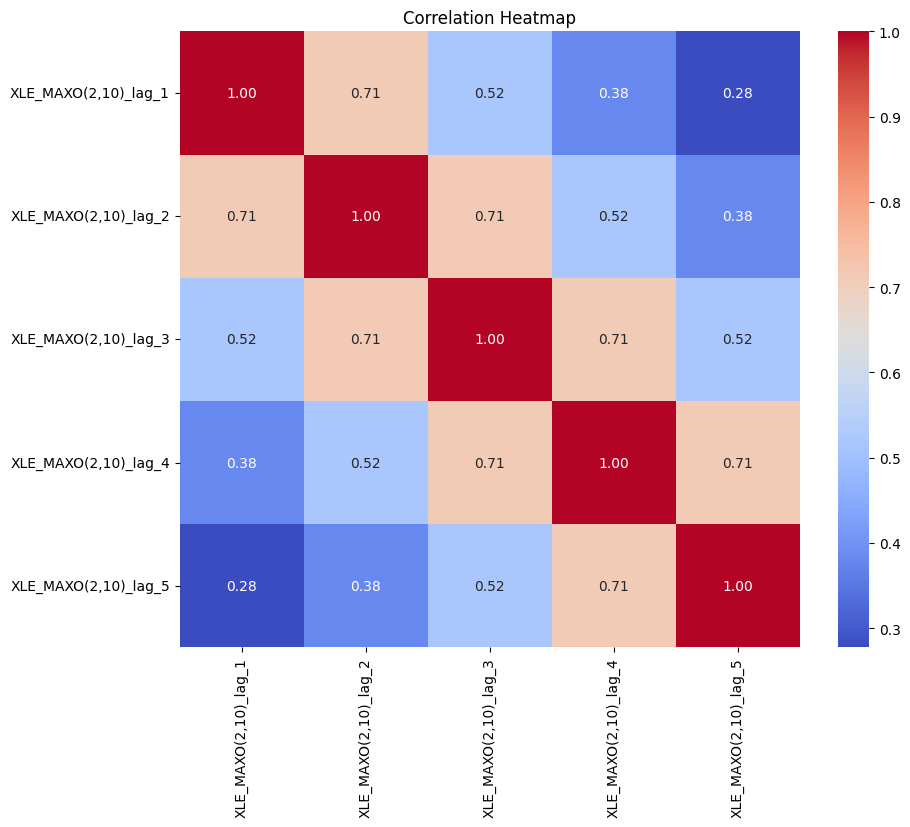

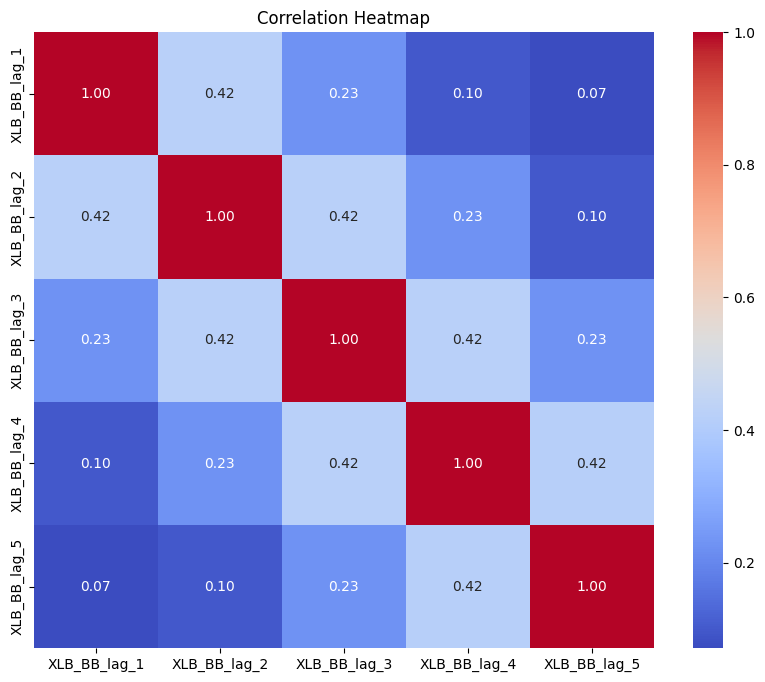

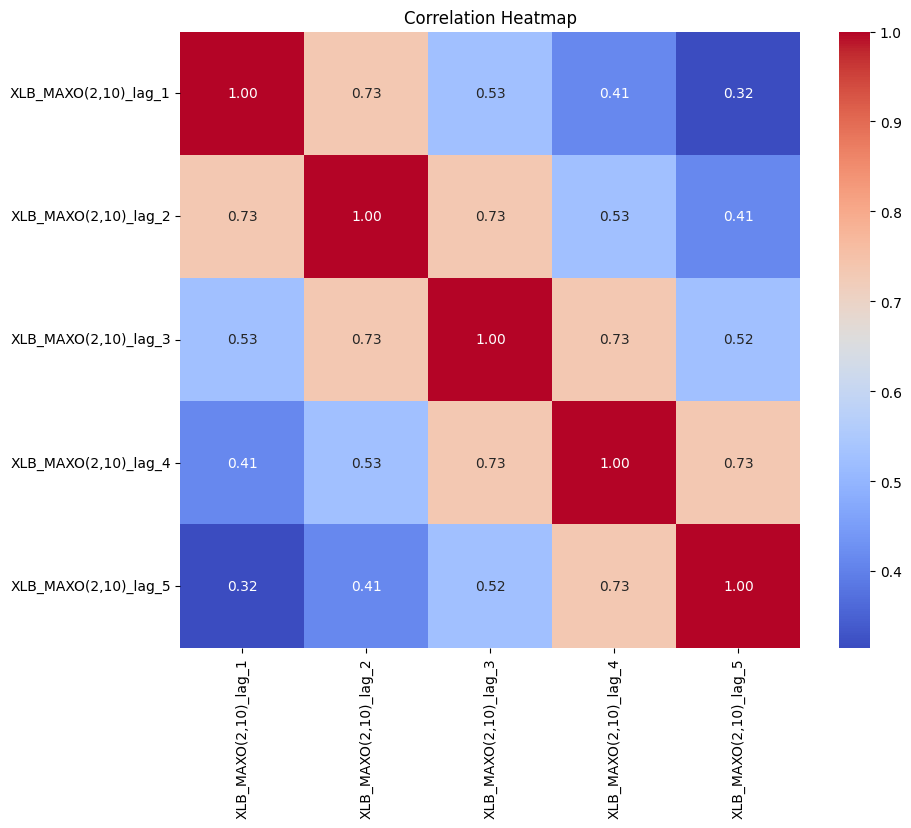

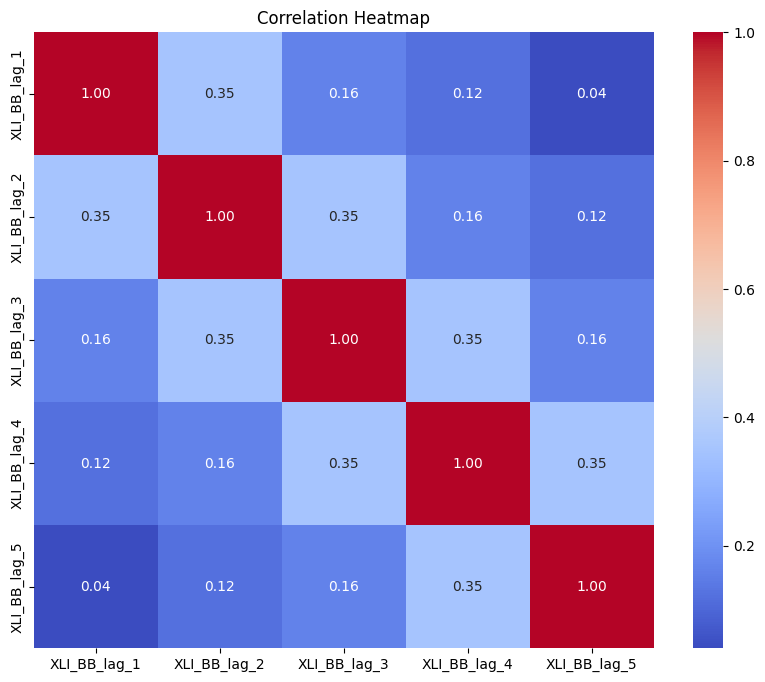

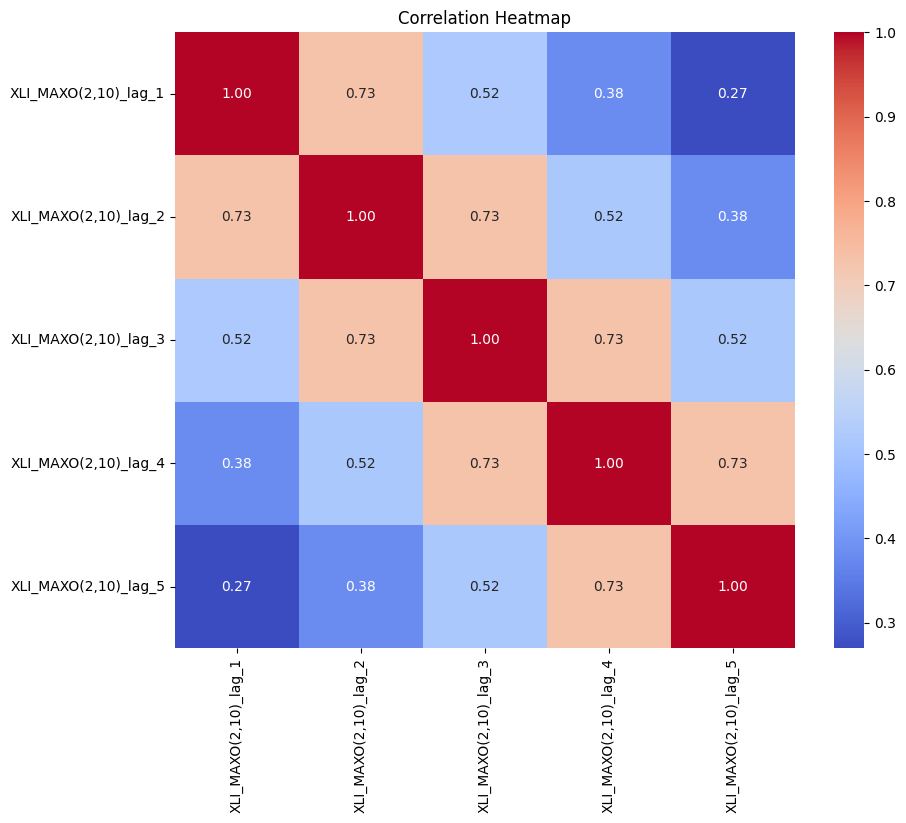

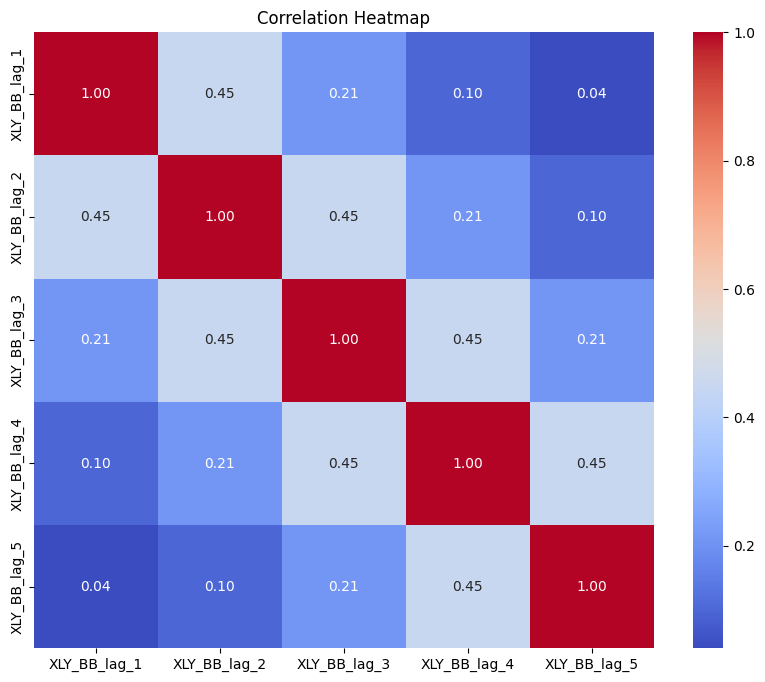

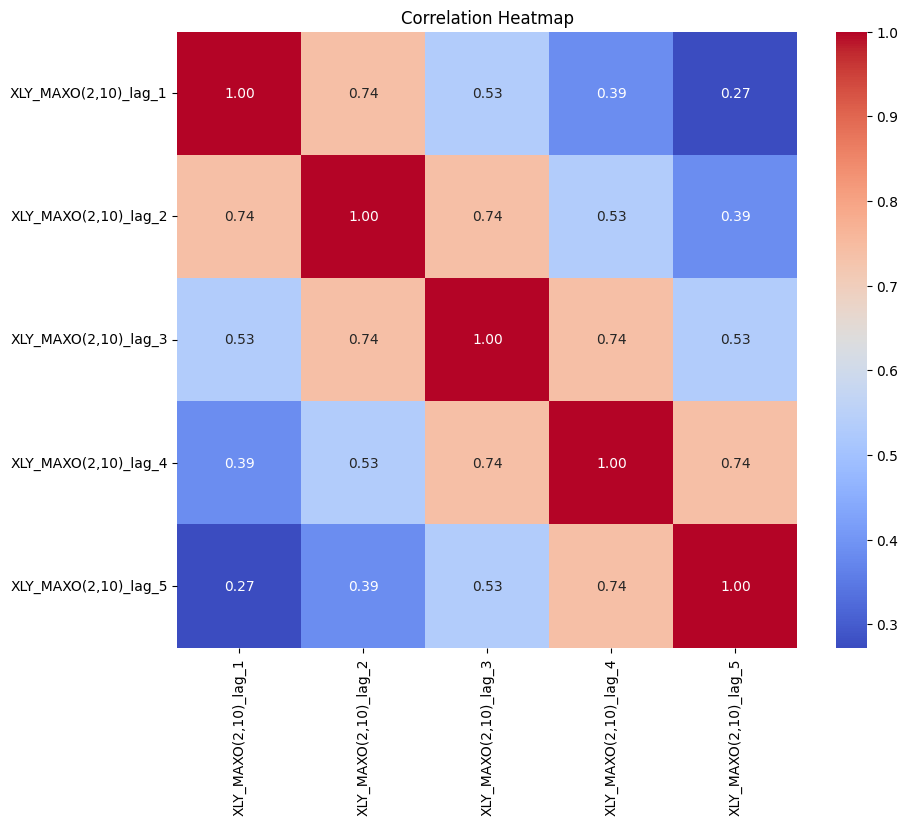

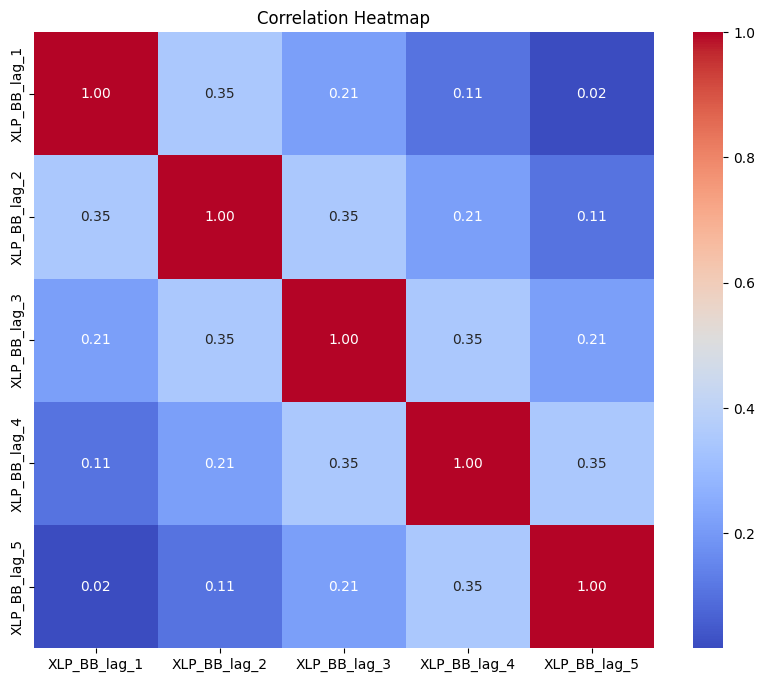

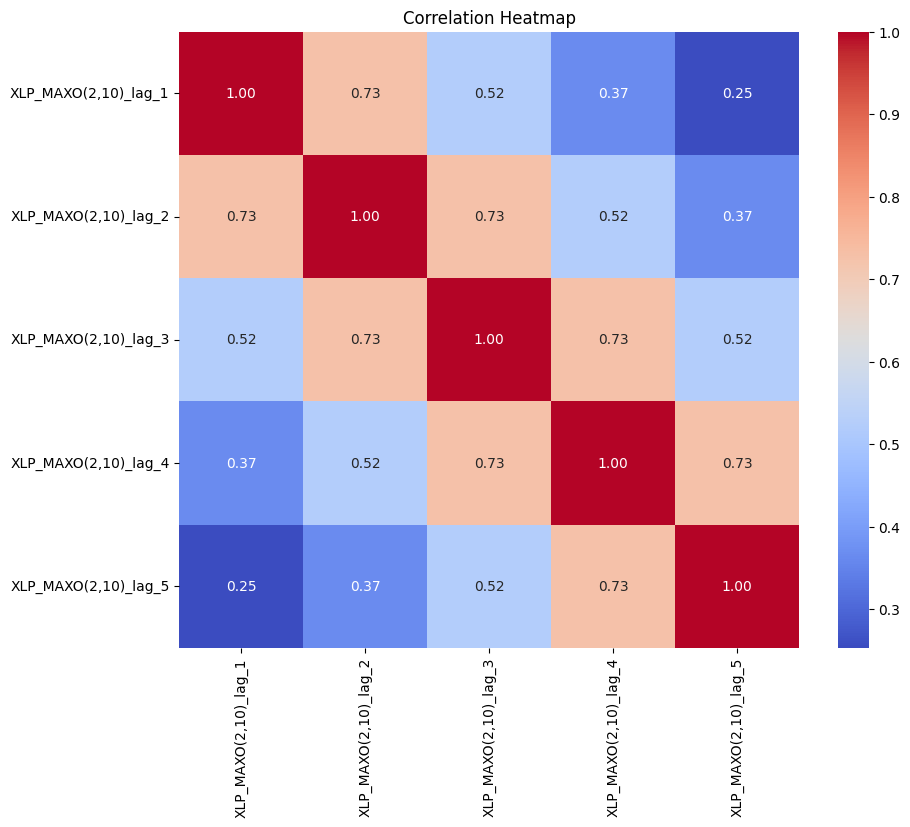

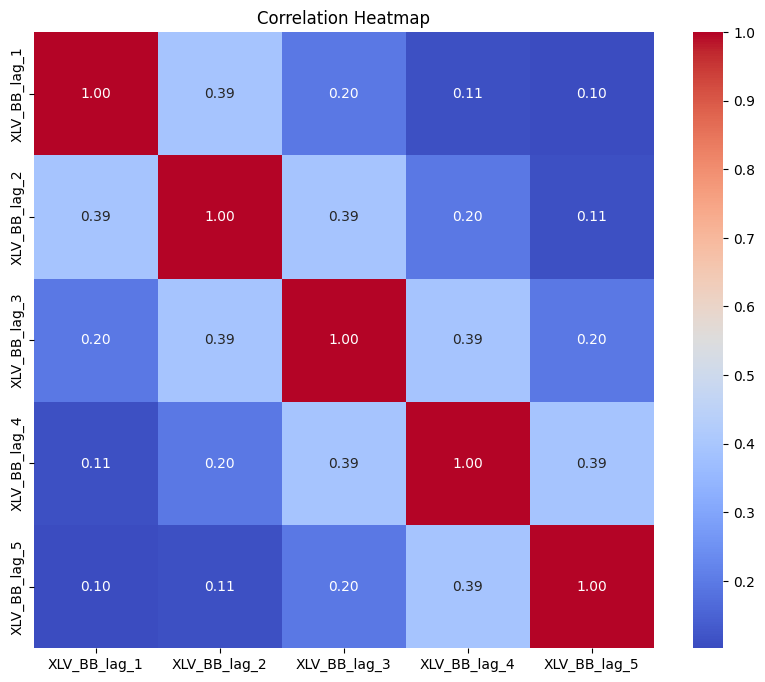

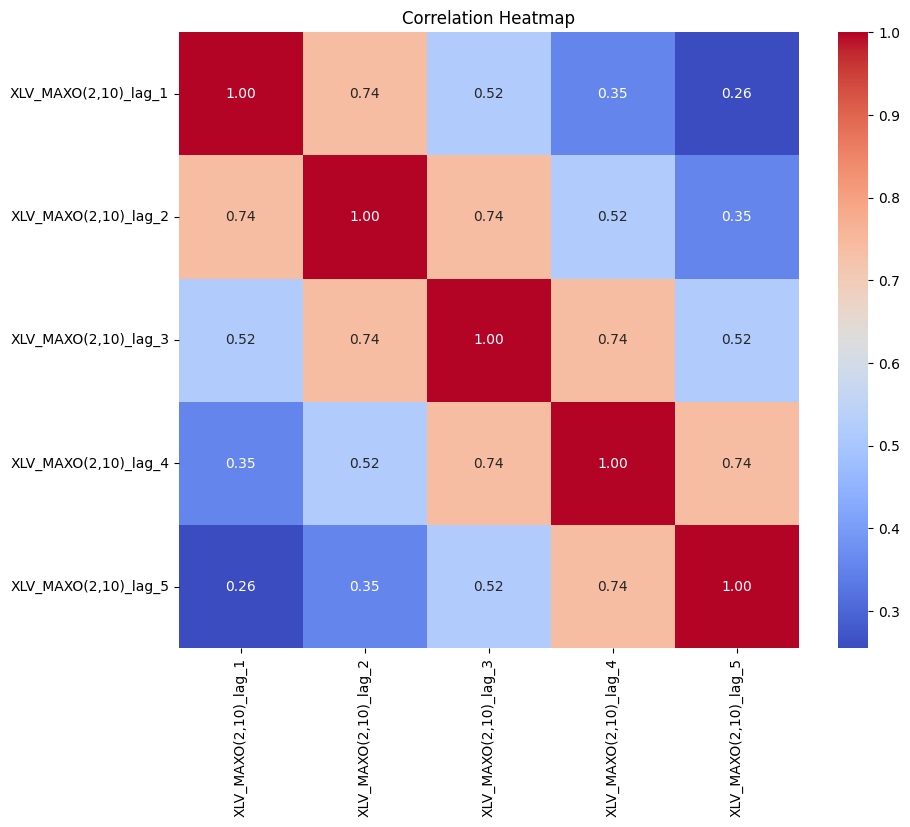

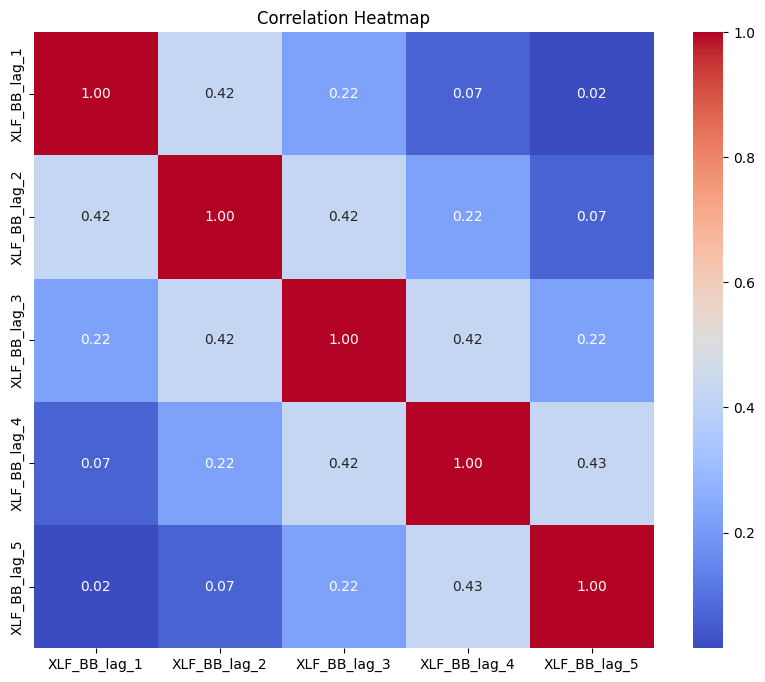

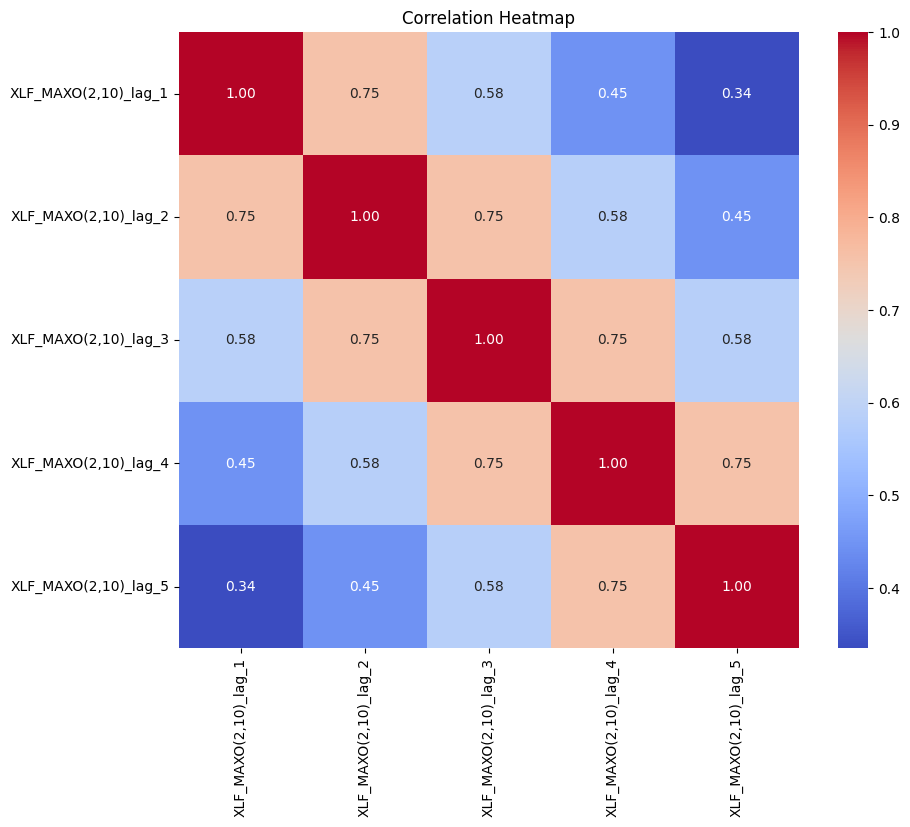

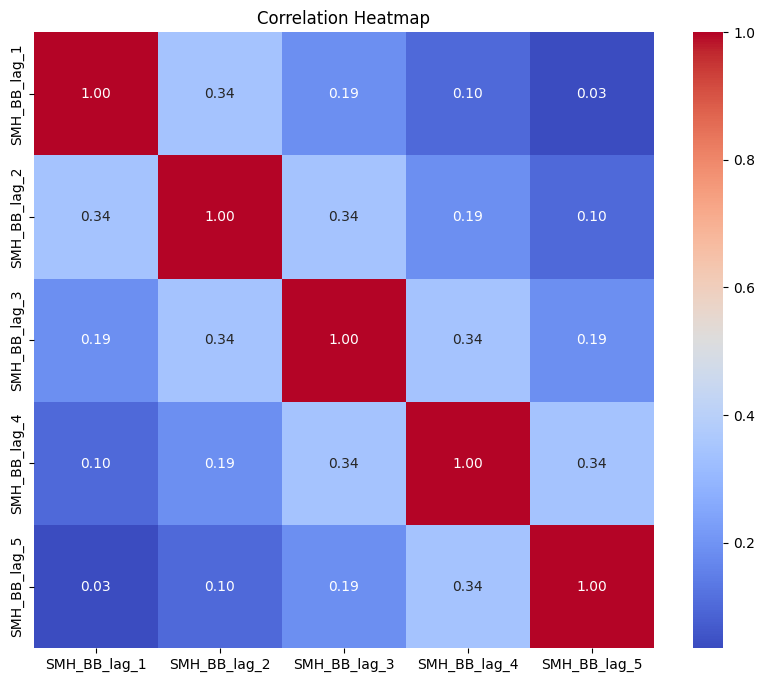

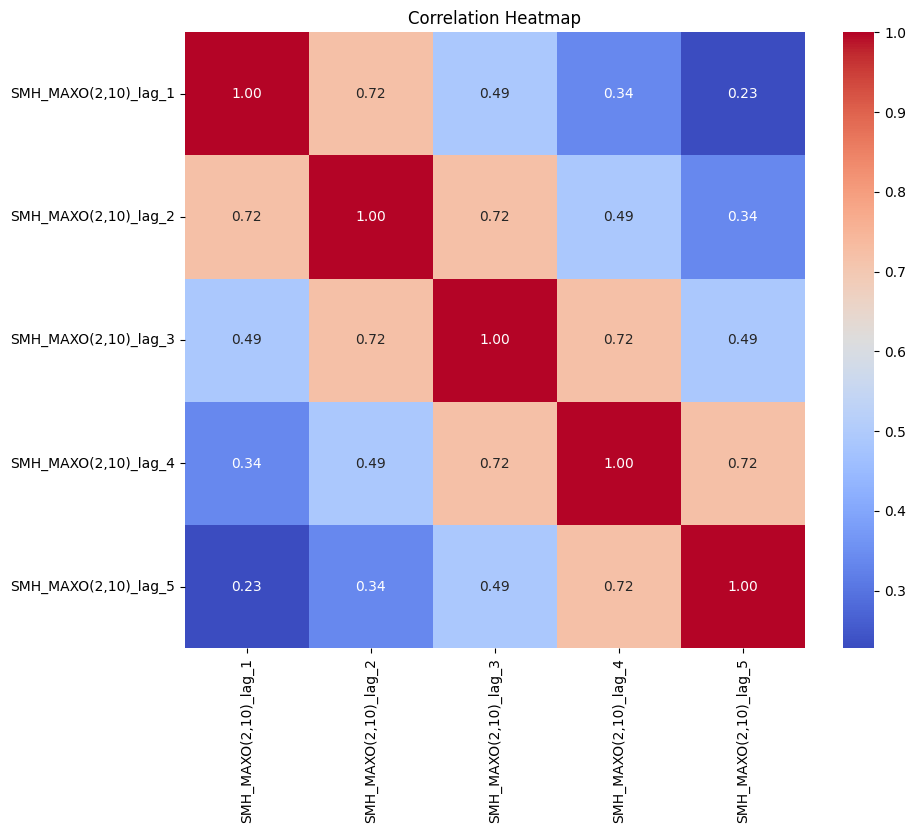

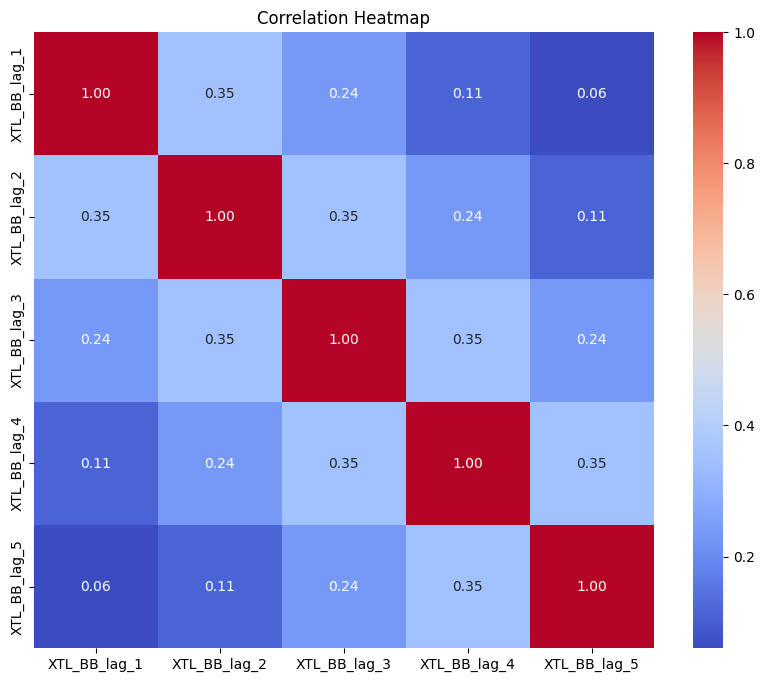

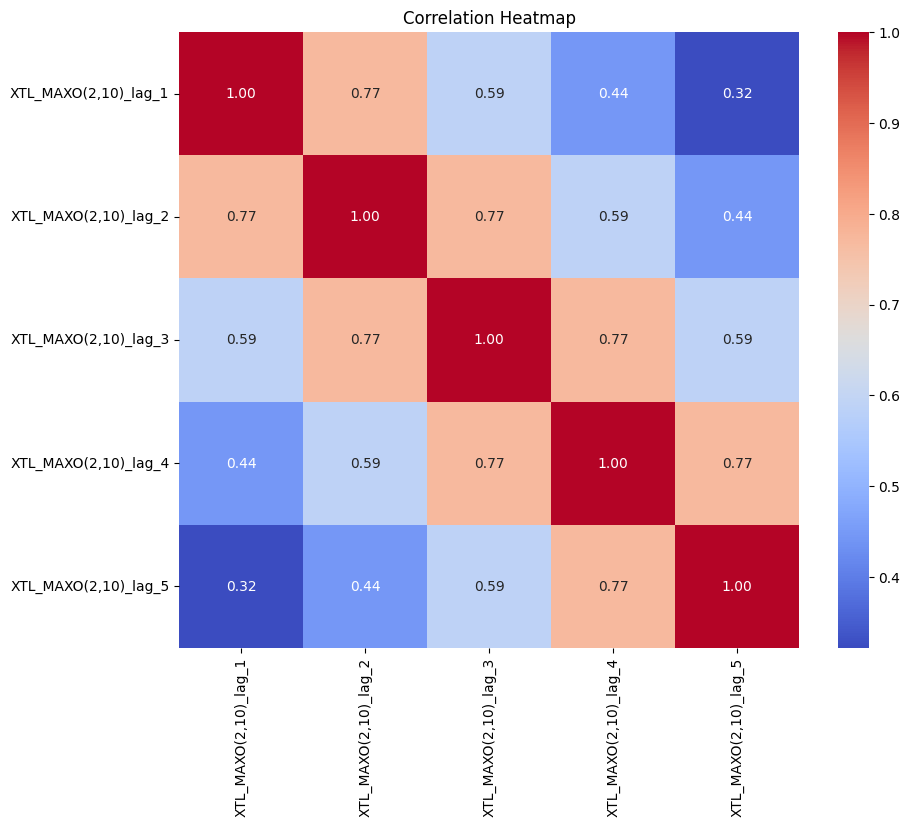

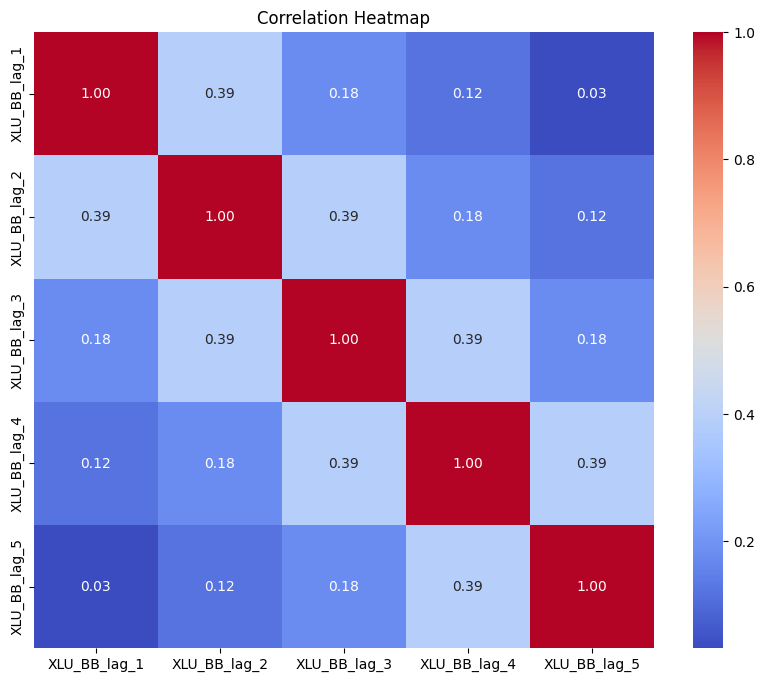

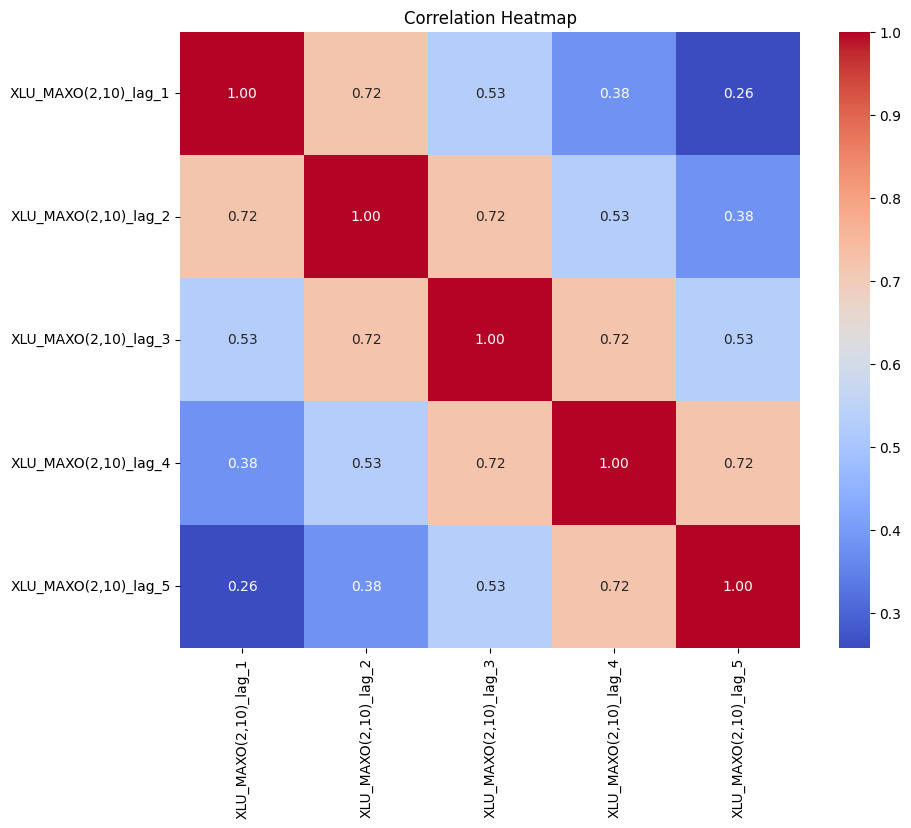

In [ ]:
for asset in columns:
    LAG_CORR(test_df, asset, lag=5, TI = 'BB')
    LAG_CORR(test_df, asset, lag=5, TI = 'MAXO(2,10)')

In [ ]:
vix = pd.read_csv('VIXCLS.csv')
vix['VIXCLS'] = pd.to_numeric(vix['VIXCLS'], errors='coerce')

# vix['volatility'] = vix['VIXCLS'].shift(1).expanding().std().fillna(method='bfill') # Or another method, e.g., fillna(vix['volatility'].mean(), inplace=True)
vix['volatility'] = vix['VIXCLS'].shift(1).expanding().std()

vix.dropna(subset=['VIXCLS'], inplace=True)
vix.rename(columns={'DATE': 'Date'}, inplace=True)

vix['Date'] = pd.to_datetime(vix['Date'])

if isinstance(test_df.index, pd.DatetimeIndex):
    test_df.reset_index(inplace=True)

all_data = pd.merge(test_df, vix, on='Date')
all_data = all_data.set_index('Date')
all_data

XLE       XLB       XLI       XLY       XLP       XLV  \
Date                                                                     
2019-04-22   82.3606   66.7031   90.5864  131.8752   69.0321   96.6237   
2019-04-23   82.2286   67.0050   91.3754  133.4512   68.8137   98.1522   
2019-04-24   80.7881   66.5869   91.1085  133.5733   68.9593   98.0398   
2019-04-25   80.5360   65.7390   89.2752  132.8741   68.5225   99.0514   
2019-04-26   79.4916   66.2849   89.9482  133.9285   69.1414  100.0404   
...              ...       ...       ...       ...       ...       ...   
2024-02-26  132.5318  110.8400  151.3750  211.0369  102.5136  179.6522   
2024-02-27  131.9634  111.2509  151.6020  211.7332  102.5274  179.2125   
2024-02-28  131.7022  111.5977  152.1190  212.5688  102.6375  178.3210   
2024-02-29  132.3475  112.4452  152.5856  214.0078  102.4723  176.8676   
2024-03-01  134.0392  113.1002  152.9639  214.5475  102.4379  178.4614   

                XLF       SMH      XTL      XLU  ...  XLU_BB_lag_3  \
Date                                             ...                 
2019-04-22  31.0688   65.7035  83.2675  74.0688  ...           NaN   
2019-04-23  31.2626   66.2341  83.6139  74.2759  ...           NaN   
2019-04-24  31.2284   66.7982  83.2818  74.7547  ...           NaN   
2019-04-25  31.2854   65.4801  81.6152  75.0652  ...           0.0   
2019-04-26  31.5703   64.6814  81.6603  75.1817  ...           0.0   
...             ...       ...      ...      ...  ...           ...   
2024-02-26  50.4369  245.6889  87.9472  91.4811  ...           0.0   
2024-02-27  50.5753  244.9764  88.6005  93.2131  ...           0.0   
2024-02-28  50.7640  242.2550  87.7009  93.4993  ...           0.0   
2024-02-29  50.7388  247.5577  88.2741  93.5294  ...           0.0   
2024-03-01  50.6386  256.4345  88.8544  92.4224  ...           0.0   

            XLU_BB_lag_4  XLU_BB_lag_5  XLU_MAXO(2,10)_lag_1  \
Date                                                           
2019-04-22           NaN           NaN                   NaN   
2019-04-23           NaN           NaN                  -1.0   
2019-04-24           NaN           NaN                  -1.0   
2019-04-25           NaN           NaN                  -1.0   
2019-04-26           0.0           NaN                  -1.0   
...                  ...           ...                   ...   
2024-02-26           0.0           0.0                   1.0   
2024-02-27           0.0           0.0                   1.0   
2024-02-28           0.0           0.0                   1.0   
2024-02-29           0.0           0.0                  -1.0   
2024-03-01           0.0           0.0                   1.0   

            XLU_MAXO(2,10)_lag_2  XLU_MAXO(2,10)_lag_3  XLU_MAXO(2,10)_lag_4  \
Date                                                                           
2019-04-22                   NaN                   NaN                   NaN   
2019-04-23                   NaN                   NaN                   NaN   
2019-04-24                  -1.0                   NaN                   NaN   
2019-04-25                  -1.0                  -1.0                   NaN   
2019-04-26                  -1.0                  -1.0                  -1.0   
...                          ...                   ...                   ...   
2024-02-26                   1.0                   1.0                   1.0   
2024-02-27                   1.0                   1.0                   1.0   
2024-02-28                   1.0                   1.0                   1.0   
2024-02-29                   1.0                   1.0                   1.0   
2024-03-01                  -1.0                   1.0                   1.0   

            XLU_MAXO(2,10)_lag_5  VIXCLS  volatility  
Date                                                  
2019-04-22                   NaN   12.42    3.902687  
2019-04-23                   NaN   12.28    3.902174  
2019-04-24                   NaN   13.14    3.901

In [ ]:
all_data = all_data.dropna()
all_data

XLE       XLB       XLI       XLY       XLP       XLV  \
Date                                                                     
2019-04-29   79.4196   66.1572   90.1571  133.4623   69.2263   99.8606   
2019-04-30   79.3596   66.7263   90.5168  133.2626   70.0272  100.3214   
2019-05-01   77.7750   65.5184   89.9250  131.6422   69.1656  100.1416   
2019-05-02   76.4186   65.1815   89.8786  131.7420   69.1414  100.5687   
2019-05-03   77.1268   65.8203   90.9693  133.2959   69.6631  101.3329   
...              ...       ...       ...       ...       ...       ...   
2024-02-26  132.5318  110.8400  151.3750  211.0369  102.5136  179.6522   
2024-02-27  131.9634  111.2509  151.6020  211.7332  102.5274  179.2125   
2024-02-28  131.7022  111.5977  152.1190  212.5688  102.6375  178.3210   
2024-02-29  132.3475  112.4452  152.5856  214.0078  102.4723  176.8676   
2024-03-01  134.0392  113.1002  152.9639  214.5475  102.4379  178.4614   

                XLF       SMH      XTL      XLU  ...  XLU_BB_lag_3  \
Date                                             ...                 
2019-04-29  31.8894   64.3408  81.9958  74.7417  ...           0.0   
2019-04-30  31.9350   64.9272  81.8615  75.9710  ...           0.0   
2019-05-01  31.6729   64.4301  81.0944  75.1946  ...           0.0   
2019-05-02  31.7071   65.0389  80.7587  75.0264  ...           0.0   
2019-05-03  31.9920   65.6198  82.0181  75.4405  ...           0.0   
...             ...       ...      ...      ...  ...           ...   
2024-02-26  50.4369  245.6889  87.9472  91.4811  ...           0.0   
2024-02-27  50.5753  244.9764  88.6005  93.2131  ...           0.0   
2024-02-28  50.7640  242.2550  87.7009  93.4993  ...           0.0   
2024-02-29  50.7388  247.5577  88.2741  93.5294  ...           0.0   
2024-03-01  50.6386  256.4345  88.8544  92.4224  ...           0.0   

            XLU_BB_lag_4  XLU_BB_lag_5  XLU_MAXO(2,10)_lag_1  \
Date                                                           
2019-04-29           0.0           0.0                   1.0   
2019-04-30           0.0           0.0                   1.0   
2019-05-01           0.0           0.0                   1.0   
2019-05-02           0.0           0.0                   1.0   
2019-05-03           0.0           0.0                   1.0   
...                  ...           ...                   ...   
2024-02-26           0.0           0.0                   1.0   
2024-02-27           0.0           0.0                   1.0   
2024-02-28           0.0           0.0                   1.0   
2024-02-29           0.0           0.0                  -1.0   
2024-03-01           0.0           0.0                   1.0   

            XLU_MAXO(2,10)_lag_2  XLU_MAXO(2,10)_lag_3  XLU_MAXO(2,10)_lag_4  \
Date                                                                           
2019-04-29                  -1.0                  -1.0                  -1.0   
2019-04-30                   1.0                  -1.0                  -1.0   
2019-05-01                   1.0                   1.0                  -1.0   
2019-05-02                   1.0                   1.0                   1.0   
2019-05-03                   1.0                   1.0                   1.0   
...                          ...                   ...                   ...   
2024-02-26                   1.0                   1.0                   1.0   
2024-02-27                   1.0                   1.0                   1.0   
2024-02-28                   1.0                   1.0                   1.0   
2024-02-29                   1.0                   1.0                   1.0   
2024-03-01                  -1.0                   1.0                   1.0   

            XLU_MAXO(2,10)_lag_5  VIXCLS  volatility  
Date                                                  
2019-04-29                  -1.0   13.11    3.899542  
2019-04-30                  -1.0   13.12    3.898793  
2019-05-01                  -1.0   14.80    3.898

In [ ]:
models_2_BB_ = {}

for asset in columns:
    models_2_BB_[asset] = OLS_2(all_data, asset, TI = 'BB')

for asset, model_2_BB_ in models_2_BB_.items():
    print(f"Model Summary for {asset}:")
    print(model_2_BB_.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.117
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.350
Time:                        05:25:39   Log-Likelihood:                 5048.6
No. Observations:                1234   AIC:                        -1.008e+04
Df Residuals:                    1227   BIC:                        -1.005e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.145e-05  

In [ ]:
models_2_MAXO_ = {}

for asset in columns:
    models_2_MAXO_[asset] = OLS_2(all_data, asset, TI = 'MAXO(2,10)')

for asset, model_2_MAXO_ in models_2_MAXO_.items():
    print(f"Model Summary for {asset}:")
    print(model_2_MAXO_.summary())
    print("\n" + "="*80 + "\n")

Model Summary for XLE:
                            OLS Regression Results                            
Dep. Variable:             XLE_return   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.640
Date:                Mon, 11 Mar 2024   Prob (F-statistic):              0.133
Time:                        05:25:39   Log-Likelihood:                 5050.2
No. Observations:                1234   AIC:                        -1.009e+04
Df Residuals:                    1227   BIC:                        -1.005e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const    

In [ ]:
test_df = test_df.set_index('Date', drop=True)

In [ ]:
test_df

XLE       XLB       XLI       XLY       XLP       XLV  \
Date                                                                     
2019-04-22   82.3606   66.7031   90.5864  131.8752   69.0321   96.6237   
2019-04-23   82.2286   67.0050   91.3754  133.4512   68.8137   98.1522   
2019-04-24   80.7881   66.5869   91.1085  133.5733   68.9593   98.0398   
2019-04-25   80.5360   65.7390   89.2752  132.8741   68.5225   99.0514   
2019-04-26   79.4916   66.2849   89.9482  133.9285   69.1414  100.0404   
...              ...       ...       ...       ...       ...       ...   
2024-02-26  132.5318  110.8400  151.3750  211.0369  102.5136  179.6522   
2024-02-27  131.9634  111.2509  151.6020  211.7332  102.5274  179.2125   
2024-02-28  131.7022  111.5977  152.1190  212.5688  102.6375  178.3210   
2024-02-29  132.3475  112.4452  152.5856  214.0078  102.4723  176.8676   
2024-03-01  134.0392  113.1002  152.9639  214.5475  102.4379  178.4614   

                XLF       SMH      XTL      XLU  ...  XLU_BB_lag_1  \
Date                                             ...                 
2019-04-22  31.0688   65.7035  83.2675  74.0688  ...           NaN   
2019-04-23  31.2626   66.2341  83.6139  74.2759  ...           0.0   
2019-04-24  31.2284   66.7982  83.2818  74.7547  ...           0.0   
2019-04-25  31.2854   65.4801  81.6152  75.0652  ...           0.0   
2019-04-26  31.5703   64.6814  81.6603  75.1817  ...           0.0   
...             ...       ...      ...      ...  ...           ...   
2024-02-26  50.4369  245.6889  87.9472  91.4811  ...           0.0   
2024-02-27  50.5753  244.9764  88.6005  93.2131  ...           0.0   
2024-02-28  50.7640  242.2550  87.7009  93.4993  ...           0.0   
2024-02-29  50.7388  247.5577  88.2741  93.5294  ...           0.0   
2024-03-01  50.6386  256.4345  88.8544  92.4224  ...           0.0   

            XLU_BB_lag_2  XLU_BB_lag_3  XLU_BB_lag_4  XLU_BB_lag_5  \
Date                                                                 
2019-04-22           NaN           NaN           NaN           NaN   
2019-04-23           NaN           NaN           NaN           NaN   
2019-04-24           0.0           NaN           NaN           NaN   
2019-04-25           0.0           0.0           NaN           NaN   
2019-04-26           0.0           0.0           0.0           NaN   
...                  ...           ...           ...           ...   
2024-02-26           0.0           0.0           0.0           0.0   
2024-02-27           0.0           0.0           0.0           0.0   
2024-02-28           0.0           0.0           0.0           0.0   
2024-02-29           0.0           0.0           0.0           0.0   
2024-03-01           0.0           0.0           0.0           0.0   

            XLU_MAXO(2,10)_lag_1  XLU_MAXO(2,10)_lag_2  XLU_MAXO(2,10)_lag_3  \
Date                                                                           
2019-04-22                   NaN                   NaN                   NaN   
2019-04-23                  -1.0                   NaN                   NaN   
2019-04-24                  -1.0                  -1.0                   NaN   
2019-04-25                  -1.0                  -1.0                  -1.0   
2019-04-26                  -1.0                  -1.0                  -1.0   
...                          ...                   ...                   ...   
2024-02-26                   1.0                   1.0                   1.0   
2024-02-27                   1.0                   1.0                   1.0   
2024-02-28                   1.0                   1.0                   1.0   
2024-02-29                  -1.0                   1.0                   1.0   
2024-03-01                   1.0                  -1.0                   1.0   

            XLU_MAXO(2,10)_lag_4  XLU_MAXO(2,10)_lag_5  
Date                                                    
2019-04-22                   NaN                   NaN  
2019-04-23          

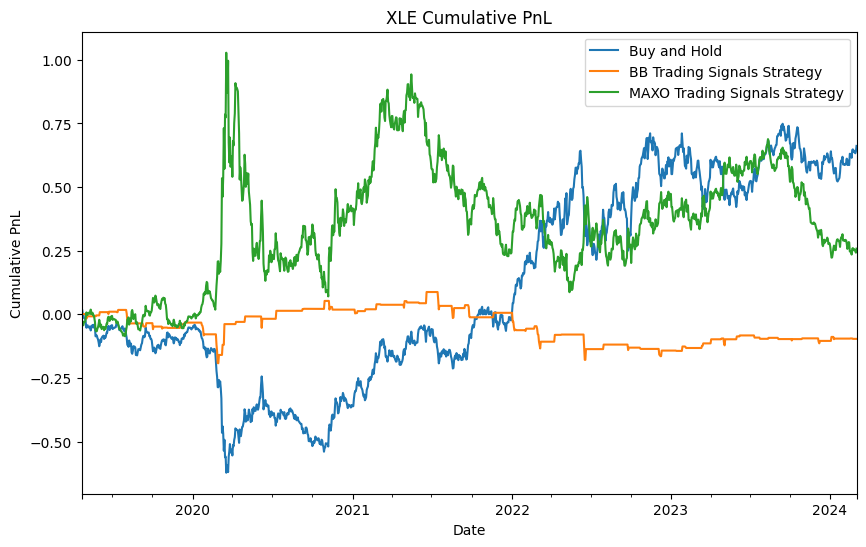

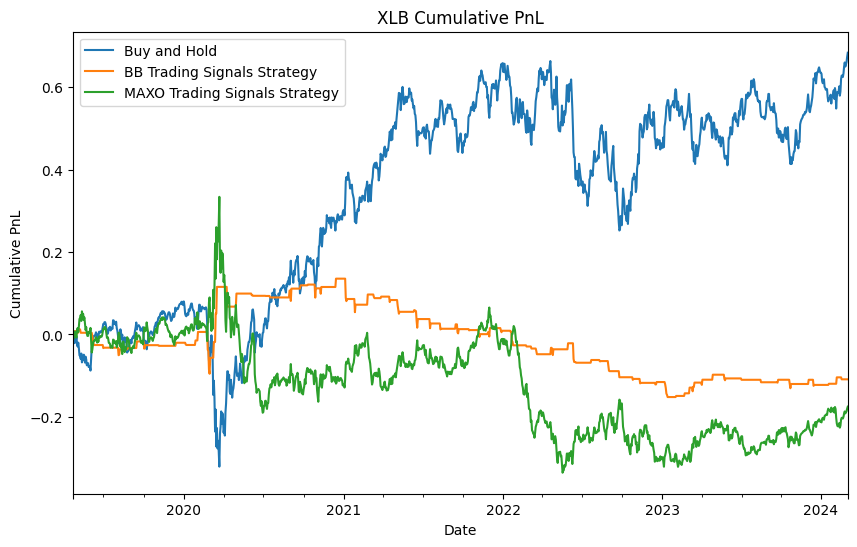

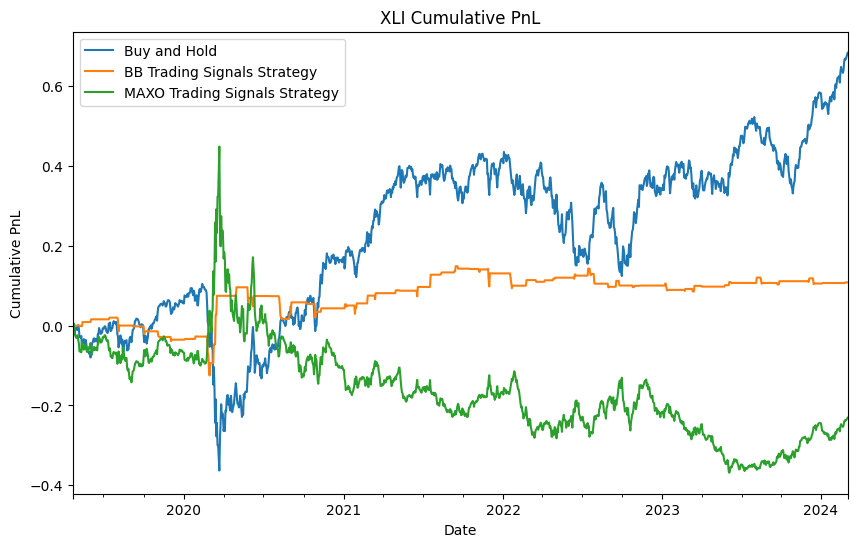

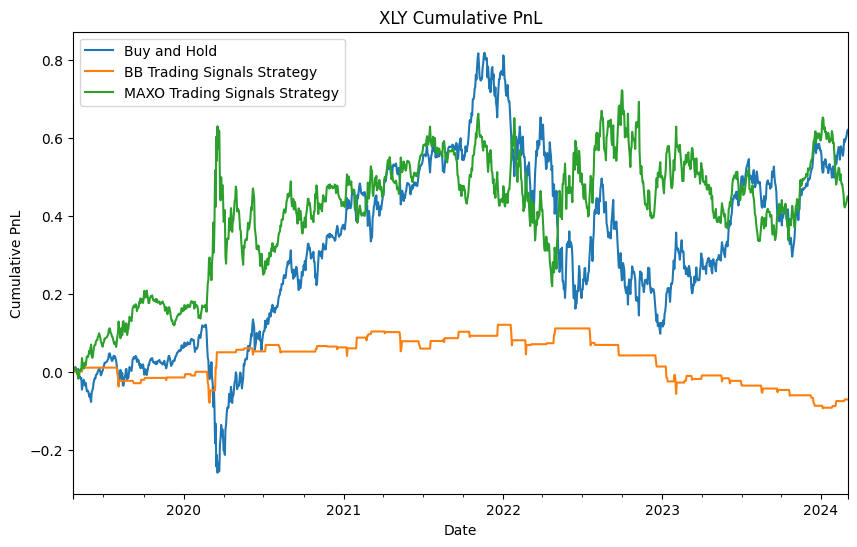

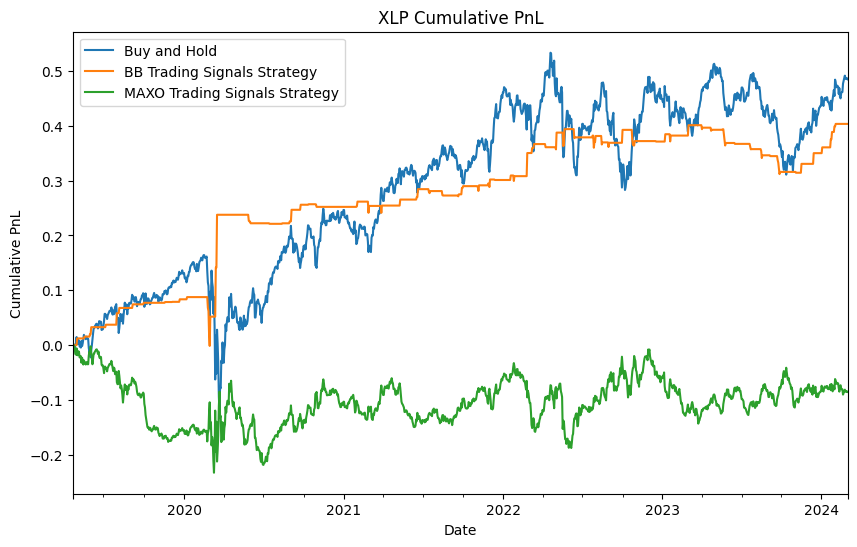

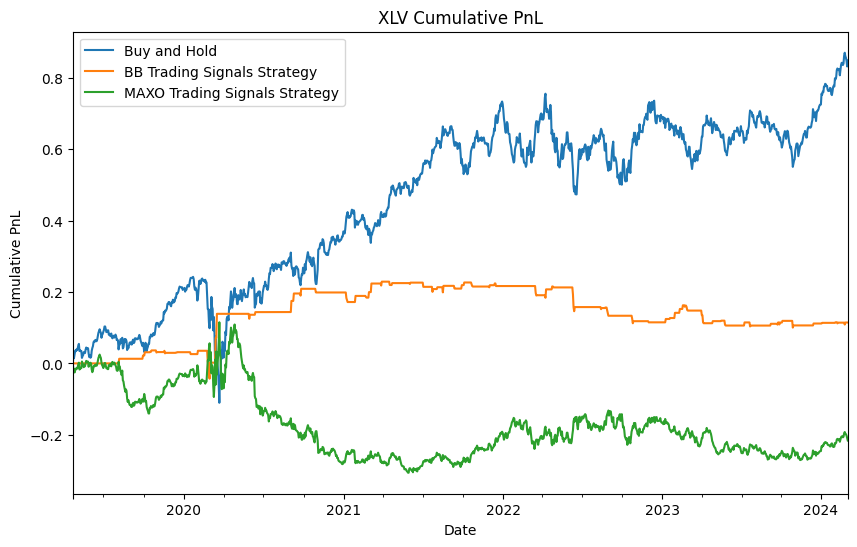

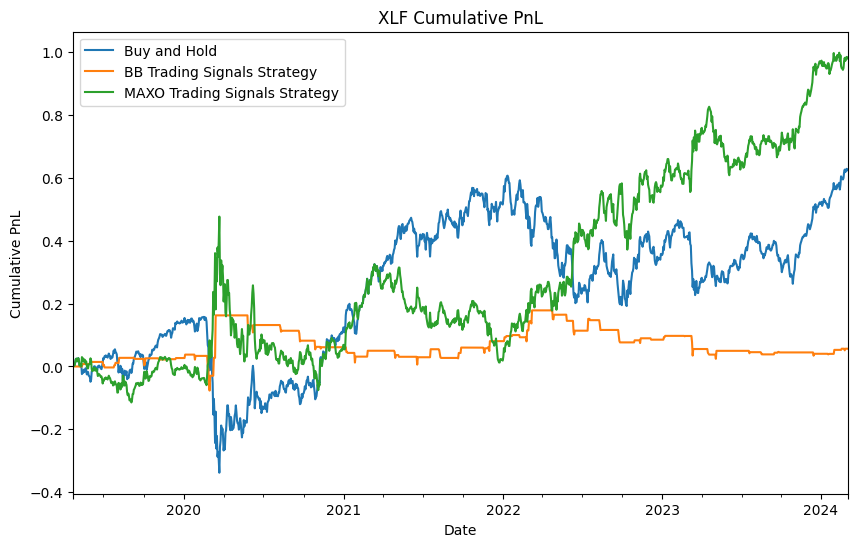

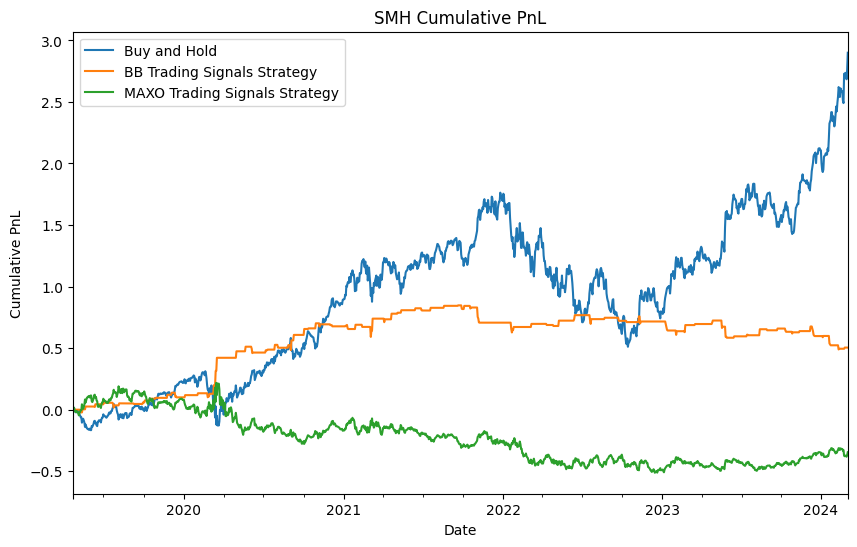

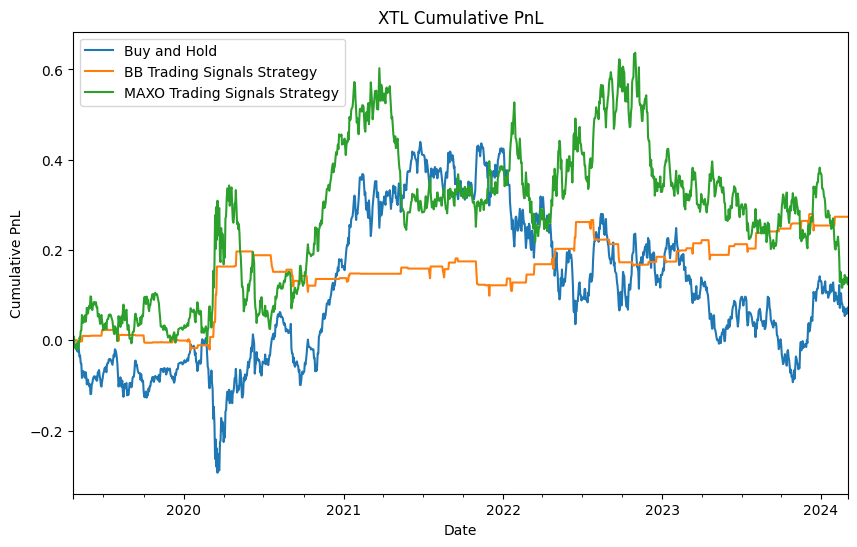

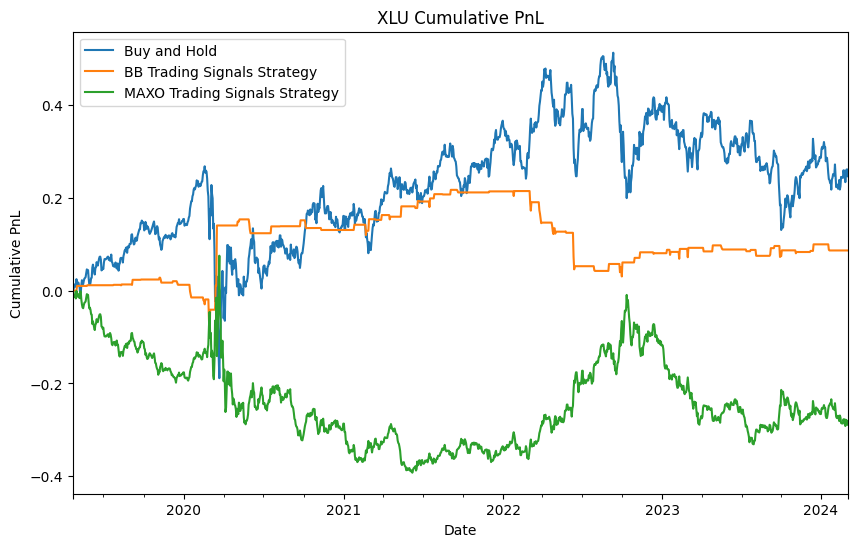

In [ ]:
for column in columns:
  test_df[f'{column}_actual pnl'] = (1 + test_df[f'{column}_return']).cumprod() - 1
  test_df[f'BBreturn_{column}'] = test_df[f'{column}_return'] * test_df[f'{column}_BB']
  test_df[f'BBpnl_{column}'] = (1 + test_df[f'BBreturn_{column}']).cumprod() - 1

  test_df[f'MAXOreturn_{column}'] = test_df[f'{column}_return'] * test_df[f'{column}_MAXO(2,10)']
  test_df[f'MAXOpnl_{column}'] = (1 + test_df[f'MAXOreturn_{column}']).cumprod() - 1
  test_df.fillna(0, inplace=True)

  plt.figure(figsize=(10, 6))
  test_df[f'{column}_actual pnl'].plot(label='Buy and Hold')
  test_df[f'BBpnl_{column}'].plot(label='BB Trading Signals Strategy')
  test_df[f'MAXOpnl_{column}'].plot(label='MAXO Trading Signals Strategy')
  plt.legend()
  plt.title(f'{column} Cumulative PnL')
  plt.xlabel('Date')
  plt.ylabel('Cumulative PnL')
  plt.show()




## Prediction  

## BB

In [ ]:

predictions_2 = {}
for asset, model_2_BB_ in models_2_BB_.items():
    return_column = f'{asset}_return'
    predictor_columns = [col for col in test_df.columns if col.startswith(f'{asset}_BB')]
    X_test = test_df[predictor_columns]
    y_test = test_df[return_column]

    X_test = sm.add_constant(X_test, has_constant='add')

    # model = models_2_BB_[asset]

    if X_test.shape[1] == model_2_BB_.params.shape[0]:
        predictions_2[f'{asset}_BB_predicted_return'] = model_2_BB_.predict(X_test)
    else:
        print(f"Error: Model for {asset} was trained with {model_2_BB_.params.shape[0]} features, but X_test has {X_test.shape[1]} features.")


predictions_df_2 = pd.DataFrame(predictions_2, index=test_df.index)



In [ ]:
model_2_BB_.params

const           0.000045
XLU_BB          0.002243
XLU_BB_lag_1   -0.004197
XLU_BB_lag_2    0.004624
XLU_BB_lag_3   -0.002344
XLU_BB_lag_4    0.000604
XLU_BB_lag_5   -0.000387
dtype: float64

In [ ]:
X_test

const  XLU_BB  XLU_BB_lag_1  XLU_BB_lag_2  XLU_BB_lag_3  \
Date                                                                  
2019-04-22    1.0     0.0           0.0           0.0           0.0   
2019-04-23    1.0     0.0           0.0           0.0           0.0   
2019-04-24    1.0     0.0           0.0           0.0           0.0   
2019-04-25    1.0     0.0           0.0           0.0           0.0   
2019-04-26    1.0     0.0           0.0           0.0           0.0   
...           ...     ...           ...           ...           ...   
2024-02-26    1.0     0.0           0.0           0.0           0.0   
2024-02-27    1.0     0.0           0.0           0.0           0.0   
2024-02-28    1.0     0.0           0.0           0.0           0.0   
2024-02-29    1.0     0.0           0.0           0.0           0.0   
2024-03-01    1.0     0.0           0.0           0.0           0.0   

            XLU_BB_lag_4  XLU_BB_lag_5  
Date                                    
2019-04-22           0.0           0.0  
2019-04-23           0.0           0.0  
2019-04-24           0.0           0.0  
2019-04-25           0.0           0.0  
2019-04-26           0.0           0.0  
...                  ...           ...  
2024-02-26           0.0           0.0  
2024-02-27           0.0           0.0  
2024-02-28           0.0           0.0  
2024-02-29           0.0           0.0  
2024-03-01           0.0           0.0  

[1270 rows x 7 columns]

In [ ]:
predictions_df_2 = predictions_df_2.dropna()

In [ ]:
# import matplotlib.pyplot as plt

# # Choose an asset for demonstration
# asset = list(models_2_BB_.keys())[0]  # Example: use the first asset from the model keys
# return_column = f'{asset}_return'
# predicted_return_column = f'{asset}_BB_predicted_return'

# if return_column in test_df.columns and predicted_return_column in predictions_df_2.columns:
#     # Calculate trading signal (1 for buy, 0 for hold) based on predicted returns
#     trading_signal = (predictions_df_2[predicted_return_column] > 0).astype(int)

#     # Calculate daily returns for trading strategy and benchmark
#     predicted_daily_returns = trading_signal.shift(1) * test_df[return_column]  # Shift to simulate next-day trading
#     buy_and_hold_daily_returns = test_df[return_column]

#     # Calculate cumulative returns for plotting
#     cumulative_predicted_returns = np.nancumsum(predicted_daily_returns)
#     cumulative_buy_and_hold_returns = np.cumsum(buy_and_hold_daily_returns)

#     # Plotting
#     plt.figure(figsize=(14, 7))
#     plt.plot(cumulative_predicted_returns, label=f'{asset} Trading Strategy PnL')
#     plt.plot(cumulative_buy_and_hold_returns, label=f'{asset} Buy and Hold Return', alpha=0.75)

#     plt.title(f'Comparative Cumulative Returns: {asset}')
#     plt.xlabel('Days')
#     plt.ylabel('Cumulative Returns')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


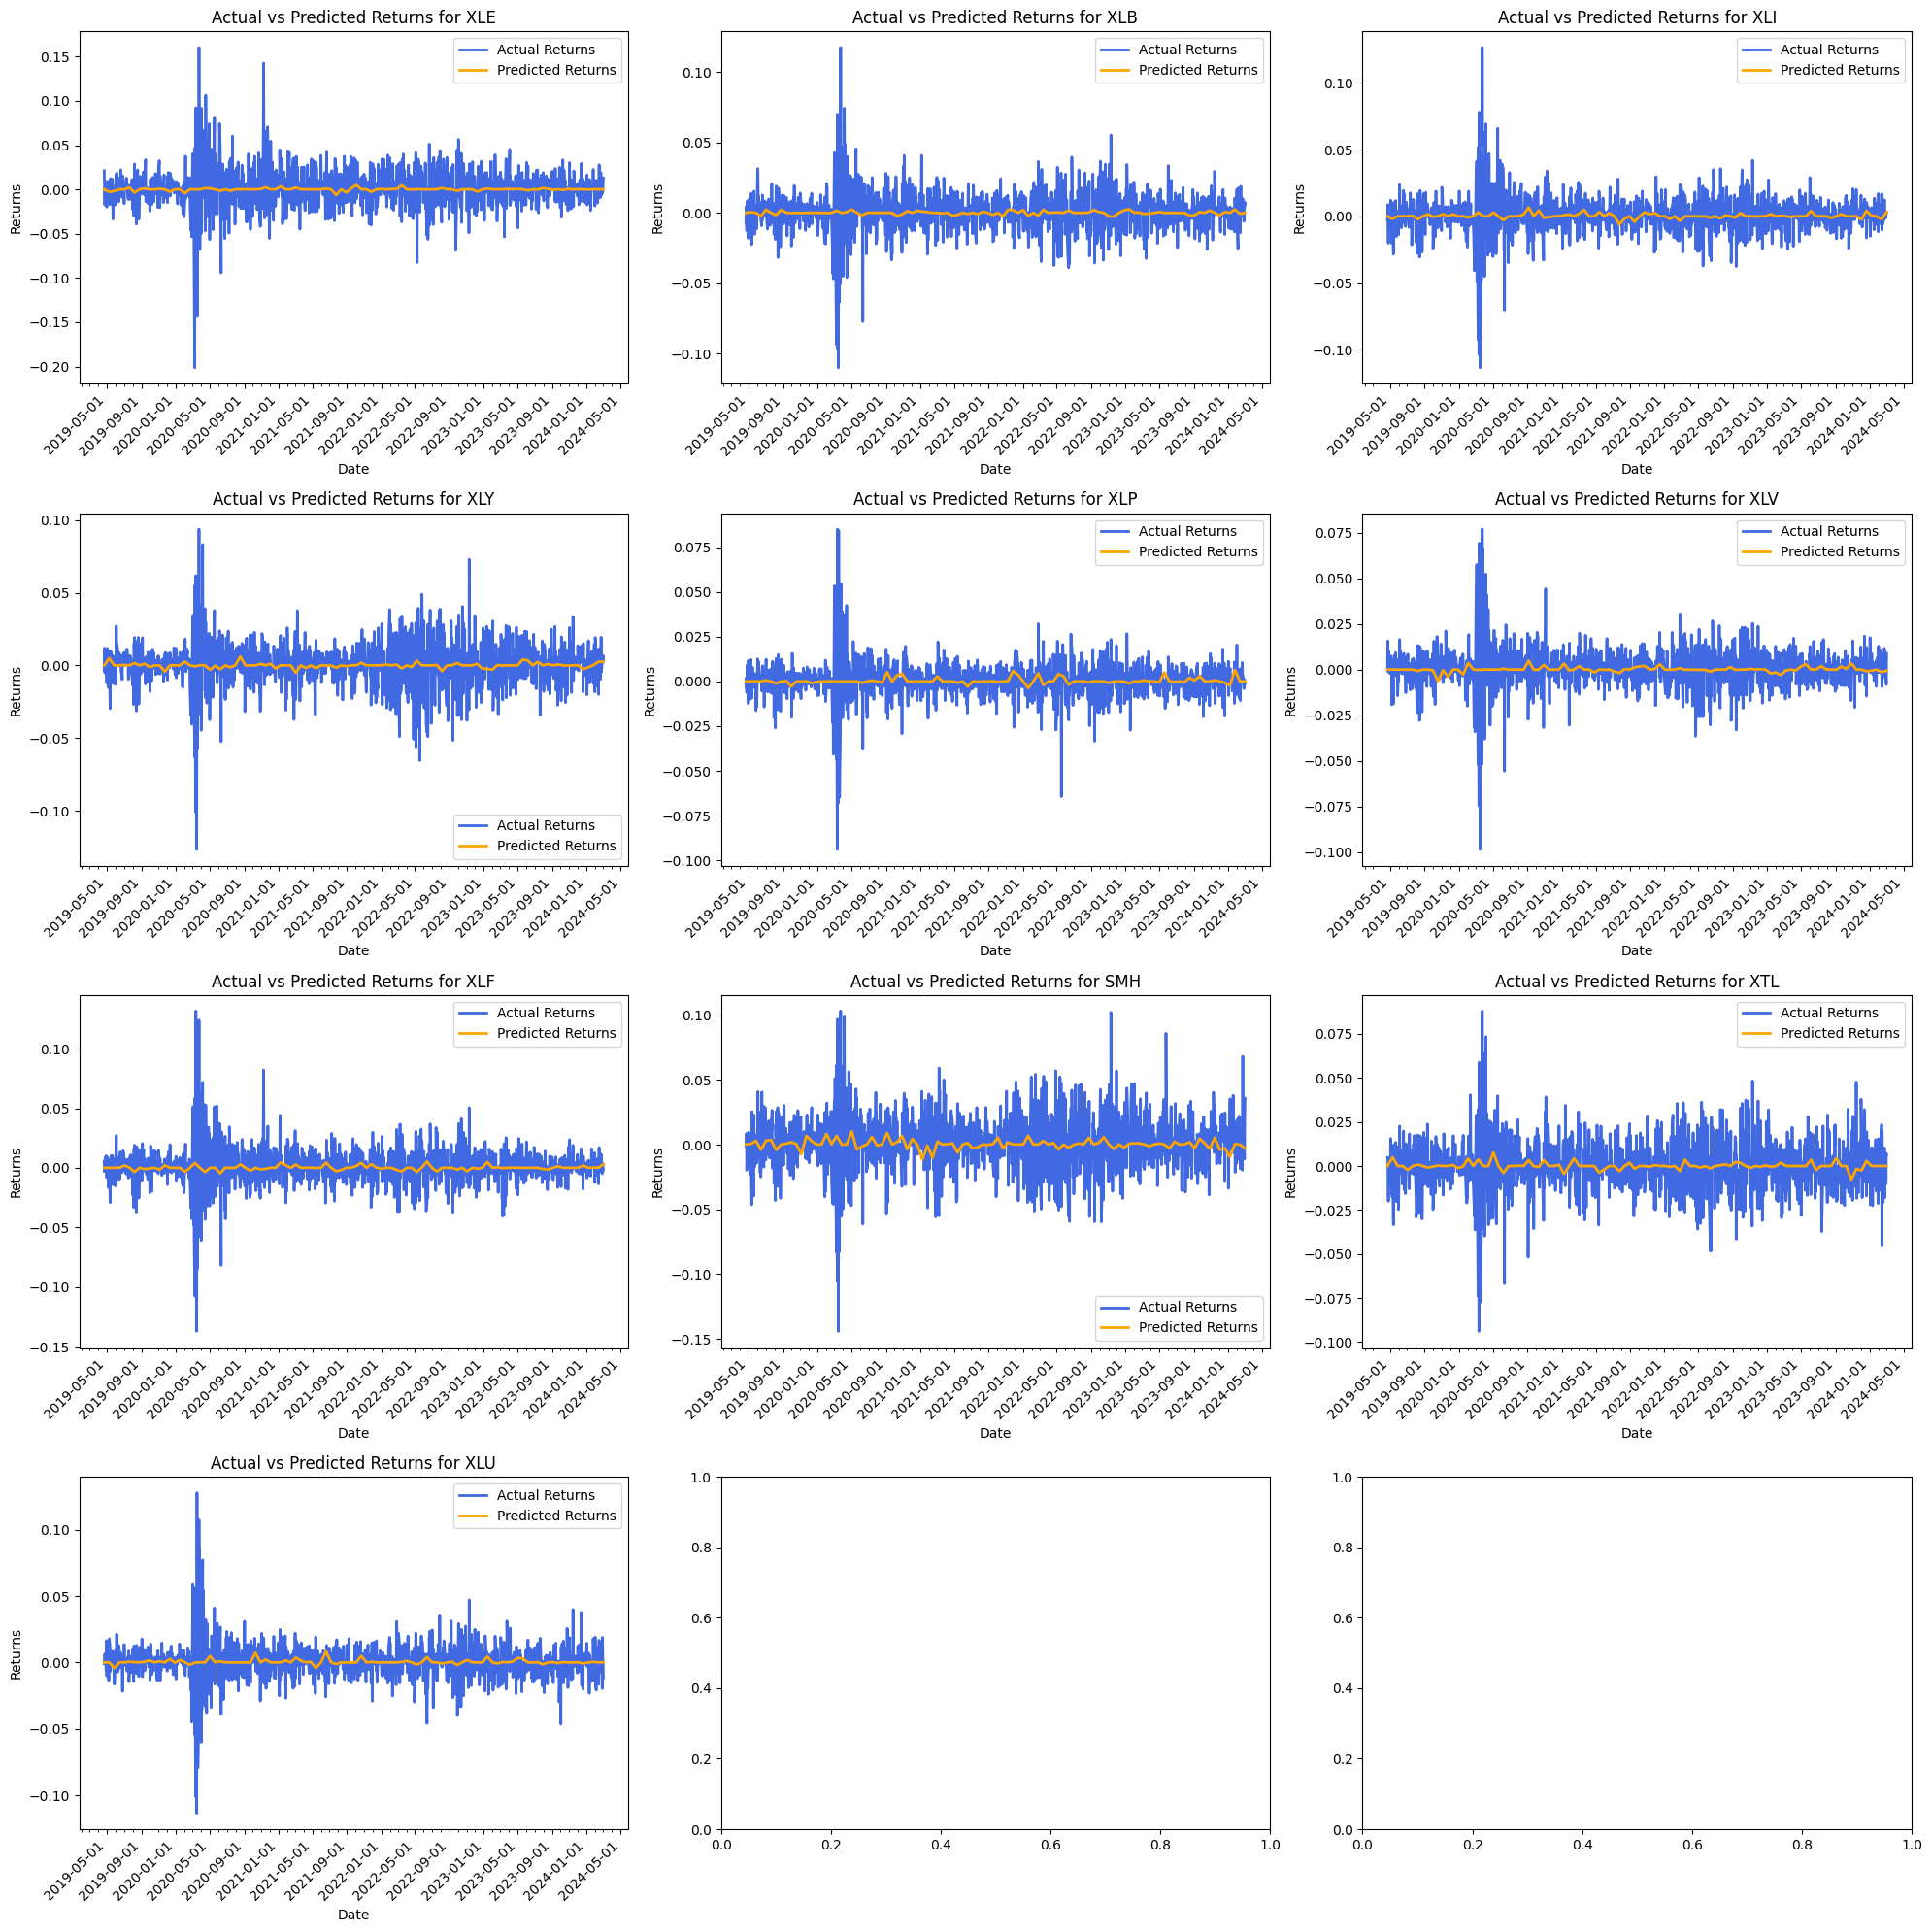

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.interpolate import make_interp_spline

num_assets = len(columns)
cols = 3
rows = np.ceil(num_assets / cols).astype(int)

fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows), squeeze=False)

for i, asset in enumerate(columns):
    ax = axs[i // cols, i % cols]

    actual_return_col = f'{asset}_return'
    ax.plot(test_df.index, test_df[actual_return_col], label='Actual Returns', marker='', color='royalblue', linewidth=2)

    predicted_return_col = f'{asset}_BB_predicted_return'
    dates = mdates.date2num(predictions_df_2.index)
    predicted_returns = predictions_df_2[predicted_return_col]
    spline = make_interp_spline(dates, predicted_returns, k=3)
    smooth_dates = np.linspace(dates.min(), dates.max(), 100)
    smooth_predicted = spline(smooth_dates)
    ax.plot(mdates.num2date(smooth_dates), smooth_predicted, label='Predicted Returns', color='orange', linewidth=2)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.set_title(f'Actual vs Predicted Returns for {asset}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.legend()

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()

plt.show()


Confusion Matrix

In [ ]:
test_df['XLU_return']

Date
2019-04-22   -0.000873
2019-04-23    0.002796
2019-04-24    0.006446
2019-04-25    0.004154
2019-04-26    0.001552
                ...   
2024-02-26   -0.019691
2024-02-27    0.018933
2024-02-28    0.003070
2024-02-29    0.000322
2024-03-01   -0.011836
Name: XLU_return, Length: 1270, dtype: float64

In [ ]:
true_labels = []
predicted_labels = []

threshold = 0.0  # Threshold for classifying returns as positive or negative

for asset in columns:
    actual_column = f'{asset}_return'  # Name of the column for actual returns
    predicted_column = f'{asset}_BB_predicted_return'  # Name of the column for predicted returns

    # Ensure the columns exist in the dataframes
    if actual_column in test_df.columns and predicted_column in predictions_df_2.columns:
        # Drop NA from both actual and predicted to avoid misalignment
        non_na_actual = test_df[actual_column].dropna()
        non_na_predicted = predictions_df_2[predicted_column].dropna()

        # Find common indices after dropping NA to ensure alignment
        common_indices = non_na_actual.index.intersection(non_na_predicted.index)

        # Select data only for common indices to ensure matching
        aligned_actual = non_na_actual.loc[common_indices]
        aligned_predicted = non_na_predicted.loc[common_indices]

        # Extend the true and predicted labels based on the threshold
        true_labels.extend([1 if r > threshold else 0 for r in aligned_actual])
        predicted_labels.extend([1 if r > threshold else 0 for r in aligned_predicted])

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1199 5026]
 [1188 5287]]


## MAXO

In [ ]:

predictions_2 = {}
for asset, model_2_MAXO_ in models_2_MAXO_.items():
    return_column = f'{asset}_return'
    predictor_columns = [col for col in test_df.columns if col.startswith(f'{asset}_MAXO(2,10)')]
    X_test = test_df[predictor_columns]
    y_test = test_df[return_column]

    X_test = sm.add_constant(X_test, has_constant='add')

    # model = models_2_BB_[asset]

    if X_test.shape[1] == model_2_MAXO_.params.shape[0]:
        predictions_2[f'{asset}_MAXO_predicted_return'] = model_2_MAXO_.predict(X_test)
    else:
        print(f"Error: Model for {asset} was trained with {model_2_MAXO_.params.shape[0]} features, but X_test has {X_test.shape[1]} features.")

predictions_df_2 = pd.DataFrame(predictions_2, index=test_df.index)



In [ ]:
predictions_df_2 = predictions_df_2.dropna()

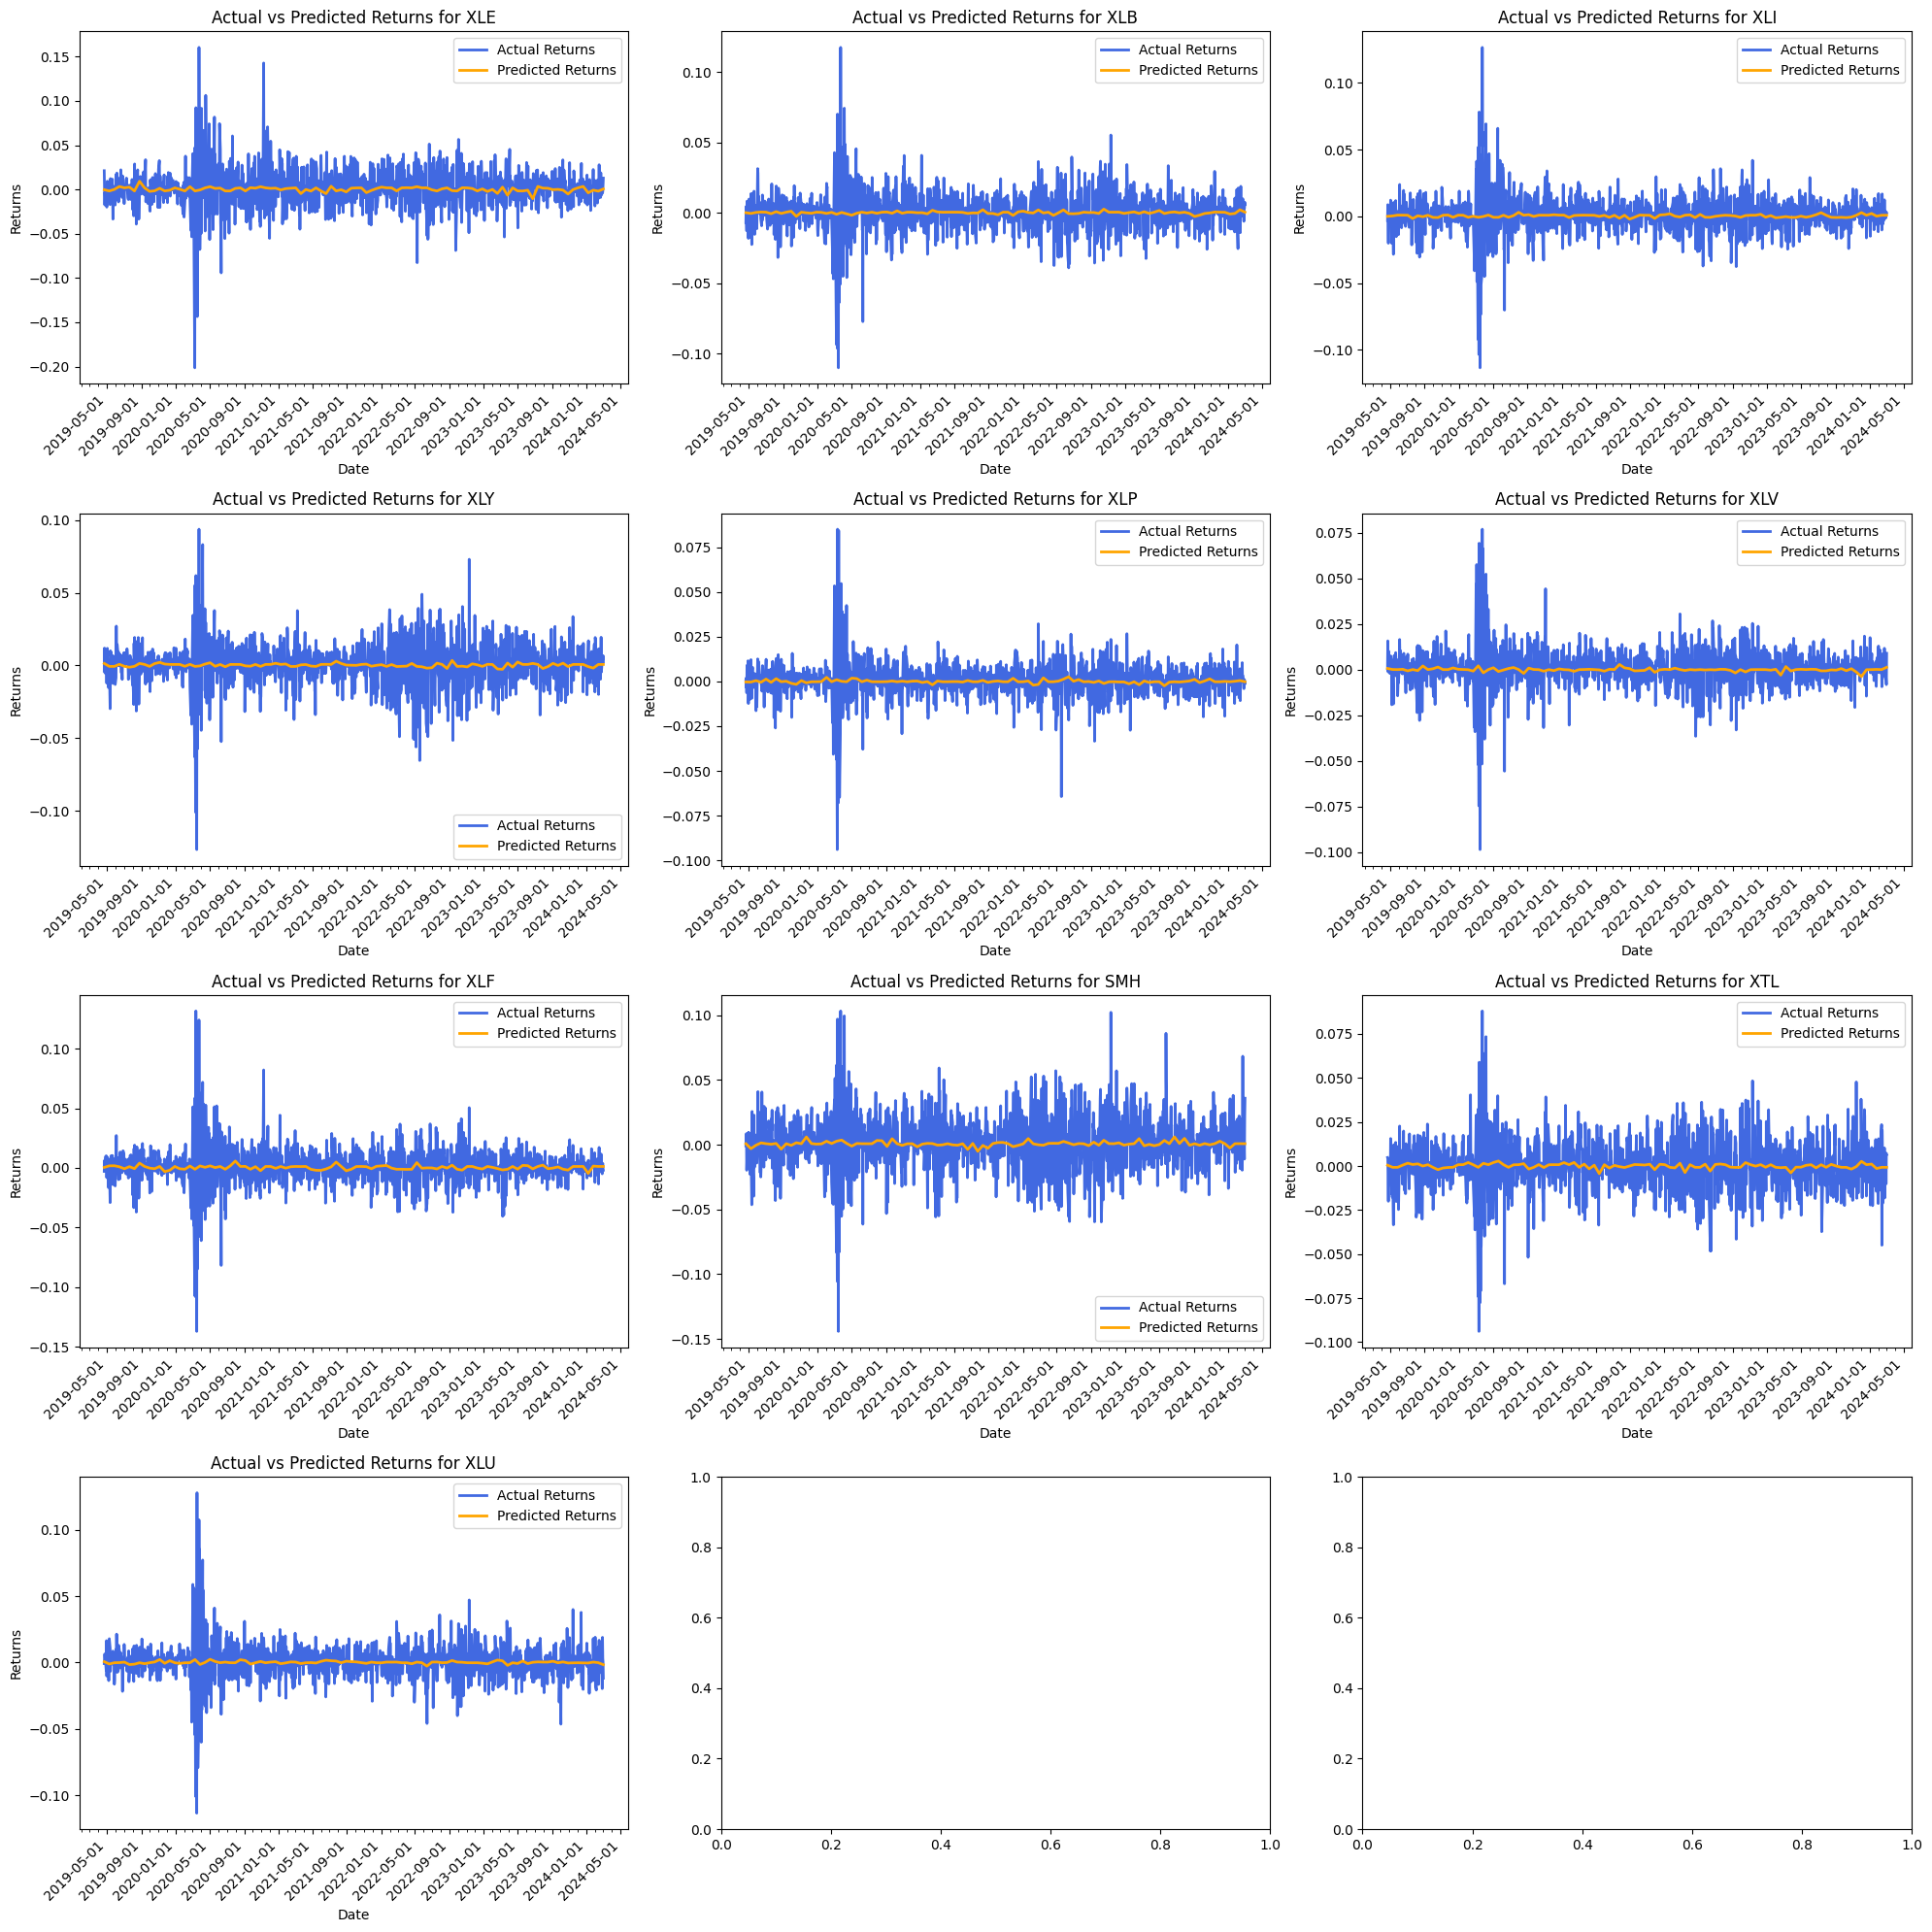

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.interpolate import make_interp_spline

num_assets = len(columns)
cols = 3
rows = np.ceil(num_assets / cols).astype(int)

fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows), squeeze=False)

for i, asset in enumerate(columns):
    ax = axs[i // cols, i % cols]

    actual_return_col = f'{asset}_return'
    ax.plot(test_df.index, test_df[actual_return_col], label='Actual Returns', marker='', color='royalblue', linewidth=2)

    predicted_return_col = f'{asset}_MAXO_predicted_return'
    dates = mdates.date2num(predictions_df_2.index)
    predicted_returns = predictions_df_2[predicted_return_col]
    spline = make_interp_spline(dates, predicted_returns, k=3)
    smooth_dates = np.linspace(dates.min(), dates.max(), 100)
    smooth_predicted = spline(smooth_dates)
    ax.plot(mdates.num2date(smooth_dates), smooth_predicted, label='Predicted Returns', color='orange', linewidth=2)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.set_title(f'Actual vs Predicted Returns for {asset}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.legend()

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()

plt.show()


In [ ]:
true_labels = []
predicted_labels = []

threshold = 0.0  # Threshold for classifying returns as positive or negative

for asset in columns:
    actual_column = f'{asset}_return'  # Name of the column for actual returns
    predicted_column = f'{asset}_MAXO_predicted_return'  # Name of the column for predicted returns

    # Ensure the columns exist in the dataframes
    if actual_column in test_df.columns and predicted_column in predictions_df_2.columns:
        # Drop NA from both actual and predicted to avoid misalignment
        non_na_actual = test_df[actual_column].dropna()
        non_na_predicted = predictions_df_2[predicted_column].dropna()

        # Find common indices after dropping NA to ensure alignment
        common_indices = non_na_actual.index.intersection(non_na_predicted.index)

        # Select data only for common indices to ensure matching
        aligned_actual = non_na_actual.loc[common_indices]
        aligned_predicted = non_na_predicted.loc[common_indices]

        # Extend the true and predicted labels based on the threshold
        true_labels.extend([1 if r > threshold else 0 for r in aligned_actual])
        predicted_labels.extend([1 if r > threshold else 0 for r in aligned_predicted])

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[2833 3392]
 [2808 3667]]
